Use kernal conda_tensorflow_p36

In [5]:
import datetime as dt
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

plt.style.use('ggplot')

Using TensorFlow backend.


## Tom Brady

In [6]:
# Read in data
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')

# Select features for RNN, along with target. Specifically, remove averages.
features = [
    'target',
    'date',
    'player_played',
    'player_home',
    'betting_over_under_line',
    'betting_spread',
    'weather_temperature',
    'weather_wind_mph',
    'weather_humidity',
    'weather_inclement',
    'defense_fumbles_forced_moving_avg_1',
    'defense_fumbles_forced_moving_avg_3',
    'defense_fumbles_forced_moving_avg_5',
    'defense_interceptions_moving_avg_1',
    'defense_interceptions_moving_avg_3',
    'defense_interceptions_moving_avg_5',
    'defense_pass_yards_allowed_moving_avg_1',
    'defense_pass_yards_allowed_moving_avg_3',
    'defense_pass_yards_allowed_moving_avg_5',
    'defense_rush_yards_allowed_moving_avg_1',
    'defense_rush_yards_allowed_moving_avg_3',
    'defense_rush_yards_allowed_moving_avg_5',
    'defense_sacks_moving_avg_1',
    'defense_sacks_moving_avg_3',
    'defense_sacks_moving_avg_5',
    'defense_points_allowed_moving_avg_1',
    'defense_points_allowed_moving_avg_3',
    'defense_points_allowed_moving_avg_5'
]

brady = brady.loc[:, features]
brady['date'] = pd.to_datetime(brady['date'])

In [7]:
# For each column in X, replace NaNs with training set naive Bayes
def replace_nans_mean(df, split):
    df_cp = df.copy()
    for col in df_cp.columns:
        if col == 'date':
            continue
        naive_estimate = df_cp.loc[:split, col].mean()
        df_cp.loc[pd.isnull(df_cp[col]), col] = naive_estimate
        
    return df_cp
        
brady = replace_nans_mean(brady, 32)

In [8]:
# Train + test set indices
split_date = pd.Timestamp(2012,5,1)
train_idx = brady.loc[brady['date']<split_date].index.values
test_idx = brady.loc[brady['date']>split_date].index.values

# Scale Features
brady.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(brady)
brady = scaler.transform(brady)

# Train + test sets
train, test = brady[train_idx], brady[test_idx]

# Split to X and Y
# X_train, X_test, y_train, y_test = X, y = brady.iloc[:,1:], brady.iloc[:,0]

In [9]:
def build_lstm_data(df, window):
    X = []
    y = []
    for i in range(len(df)-window):
        temp_set = df[i:(i+window)].copy()
        X.append(temp_set[:,1:])
        y.append(temp_set[window-1,0])

    return np.array(X), np.array(y)

In [6]:
# Create train and test sets
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [7]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [8]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=1000, batch_size=5, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()
    

W1106 23:25:35.640559 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1106 23:25:35.659396 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1106 23:25:35.662045 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1106 23:25:37.041940 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:13

Train on 26 samples, validate on 16 samples
Epoch 1/1000
 - 5s - loss: 0.3367 - val_loss: 0.2013
Epoch 2/1000
 - 0s - loss: 0.2365 - val_loss: 0.2187
Epoch 3/1000
 - 0s - loss: 0.2256 - val_loss: 0.2423
Epoch 4/1000
 - 0s - loss: 0.2935 - val_loss: 0.2265
Epoch 5/1000
 - 0s - loss: 0.2436 - val_loss: 0.2261
Epoch 6/1000
 - 0s - loss: 0.2917 - val_loss: 0.2199
Epoch 7/1000
 - 0s - loss: 0.2222 - val_loss: 0.2181
Epoch 8/1000
 - 0s - loss: 0.2558 - val_loss: 0.2212
Epoch 9/1000
 - 0s - loss: 0.2128 - val_loss: 0.2176
Epoch 10/1000
 - 0s - loss: 0.2227 - val_loss: 0.2160
Epoch 11/1000
 - 0s - loss: 0.2182 - val_loss: 0.2233
Epoch 12/1000
 - 0s - loss: 0.2116 - val_loss: 0.2321
Epoch 13/1000
 - 0s - loss: 0.2515 - val_loss: 0.2477
Epoch 14/1000
 - 0s - loss: 0.2124 - val_loss: 0.2553
Epoch 15/1000
 - 0s - loss: 0.2200 - val_loss: 0.2191
Epoch 16/1000
 - 0s - loss: 0.2075 - val_loss: 0.2123
Epoch 17/1000
 - 0s - loss: 0.1834 - val_loss: 0.2206
Epoch 18/1000
 - 0s - loss: 0.2299 - val_loss: 

 - 0s - loss: 0.1190 - val_loss: 0.1655
Epoch 152/1000
 - 0s - loss: 0.1053 - val_loss: 0.2365
Epoch 153/1000
 - 0s - loss: 0.1089 - val_loss: 0.1690
Epoch 154/1000
 - 0s - loss: 0.0909 - val_loss: 0.1585
Epoch 155/1000
 - 0s - loss: 0.1032 - val_loss: 0.1625
Epoch 156/1000
 - 0s - loss: 0.0995 - val_loss: 0.2332
Epoch 157/1000
 - 0s - loss: 0.1195 - val_loss: 0.1994
Epoch 158/1000
 - 0s - loss: 0.1047 - val_loss: 0.1480
Epoch 159/1000
 - 0s - loss: 0.1163 - val_loss: 0.2129
Epoch 160/1000
 - 0s - loss: 0.1146 - val_loss: 0.1941
Epoch 161/1000
 - 0s - loss: 0.0945 - val_loss: 0.1476
Epoch 162/1000
 - 0s - loss: 0.0994 - val_loss: 0.1534
Epoch 163/1000
 - 0s - loss: 0.0909 - val_loss: 0.1861
Epoch 164/1000
 - 0s - loss: 0.0894 - val_loss: 0.1669
Epoch 165/1000
 - 0s - loss: 0.0898 - val_loss: 0.1722
Epoch 166/1000
 - 0s - loss: 0.1070 - val_loss: 0.1942
Epoch 167/1000
 - 0s - loss: 0.0975 - val_loss: 0.1878
Epoch 168/1000
 - 0s - loss: 0.1000 - val_loss: 0.1917
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.0598 - val_loss: 0.1880
Epoch 301/1000
 - 0s - loss: 0.0655 - val_loss: 0.1785
Epoch 302/1000
 - 0s - loss: 0.0539 - val_loss: 0.1606
Epoch 303/1000
 - 0s - loss: 0.0699 - val_loss: 0.1613
Epoch 304/1000
 - 0s - loss: 0.0586 - val_loss: 0.1684
Epoch 305/1000
 - 0s - loss: 0.0503 - val_loss: 0.1747
Epoch 306/1000
 - 0s - loss: 0.0517 - val_loss: 0.2336
Epoch 307/1000
 - 0s - loss: 0.0853 - val_loss: 0.1832
Epoch 308/1000
 - 0s - loss: 0.0629 - val_loss: 0.1665
Epoch 309/1000
 - 0s - loss: 0.0520 - val_loss: 0.1890
Epoch 310/1000
 - 0s - loss: 0.0541 - val_loss: 0.1795
Epoch 311/1000
 - 0s - loss: 0.0371 - val_loss: 0.2042
Epoch 312/1000
 - 0s - loss: 0.0574 - val_loss: 0.1747
Epoch 313/1000
 - 0s - loss: 0.0579 - val_loss: 0.1801
Epoch 314/1000
 - 0s - loss: 0.0427 - val_loss: 0.1908
Epoch 315/1000
 - 0s - loss: 0.0578 - val_loss: 0.1629
Epoch 316/1000
 - 0s - loss: 0.0654 - val_loss: 0.1672
Epoch 317/1000
 - 0s - loss: 0.0588 - val_loss: 0.1761
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.0389 - val_loss: 0.1719
Epoch 450/1000
 - 0s - loss: 0.0554 - val_loss: 0.1740
Epoch 451/1000
 - 0s - loss: 0.0586 - val_loss: 0.1786
Epoch 452/1000
 - 0s - loss: 0.0406 - val_loss: 0.1580
Epoch 453/1000
 - 0s - loss: 0.0581 - val_loss: 0.1673
Epoch 454/1000
 - 0s - loss: 0.0522 - val_loss: 0.1649
Epoch 455/1000
 - 0s - loss: 0.0467 - val_loss: 0.1605
Epoch 456/1000
 - 0s - loss: 0.0556 - val_loss: 0.1565
Epoch 457/1000
 - 0s - loss: 0.0435 - val_loss: 0.1918
Epoch 458/1000
 - 0s - loss: 0.0794 - val_loss: 0.1767
Epoch 459/1000
 - 0s - loss: 0.0575 - val_loss: 0.1547
Epoch 460/1000
 - 0s - loss: 0.0712 - val_loss: 0.1707
Epoch 461/1000
 - 0s - loss: 0.0524 - val_loss: 0.1960
Epoch 462/1000
 - 0s - loss: 0.0619 - val_loss: 0.1650
Epoch 463/1000
 - 0s - loss: 0.0489 - val_loss: 0.1616
Epoch 464/1000
 - 0s - loss: 0.0472 - val_loss: 0.1677
Epoch 465/1000
 - 0s - loss: 0.0402 - val_loss: 0.1646
Epoch 466/1000
 - 0s - loss: 0.0452 - val_loss: 0.1621
Epoch 467/1000
 - 0s - lo

 - 0s - loss: 0.0503 - val_loss: 0.1657
Epoch 599/1000
 - 0s - loss: 0.0383 - val_loss: 0.1648
Epoch 600/1000
 - 0s - loss: 0.0452 - val_loss: 0.1608
Epoch 601/1000
 - 0s - loss: 0.0462 - val_loss: 0.1642
Epoch 602/1000
 - 0s - loss: 0.0468 - val_loss: 0.1589
Epoch 603/1000
 - 0s - loss: 0.0396 - val_loss: 0.1621
Epoch 604/1000
 - 0s - loss: 0.0410 - val_loss: 0.1741
Epoch 605/1000
 - 0s - loss: 0.0483 - val_loss: 0.1672
Epoch 606/1000
 - 0s - loss: 0.0338 - val_loss: 0.1715
Epoch 607/1000
 - 0s - loss: 0.0303 - val_loss: 0.1765
Epoch 608/1000
 - 0s - loss: 0.0528 - val_loss: 0.1640
Epoch 609/1000
 - 0s - loss: 0.0464 - val_loss: 0.1625
Epoch 610/1000
 - 0s - loss: 0.0452 - val_loss: 0.1672
Epoch 611/1000
 - 0s - loss: 0.0525 - val_loss: 0.1610
Epoch 612/1000
 - 0s - loss: 0.0510 - val_loss: 0.1605
Epoch 613/1000
 - 0s - loss: 0.0379 - val_loss: 0.1746
Epoch 614/1000
 - 0s - loss: 0.0444 - val_loss: 0.1676
Epoch 615/1000
 - 0s - loss: 0.0377 - val_loss: 0.1674
Epoch 616/1000
 - 0s - lo

 - 0s - loss: 0.0337 - val_loss: 0.1681
Epoch 748/1000
 - 0s - loss: 0.0283 - val_loss: 0.1639
Epoch 749/1000
 - 0s - loss: 0.0494 - val_loss: 0.1622
Epoch 750/1000
 - 0s - loss: 0.0434 - val_loss: 0.1658
Epoch 751/1000
 - 0s - loss: 0.0490 - val_loss: 0.1656
Epoch 752/1000
 - 0s - loss: 0.0461 - val_loss: 0.1603
Epoch 753/1000
 - 0s - loss: 0.0282 - val_loss: 0.1622
Epoch 754/1000
 - 0s - loss: 0.0424 - val_loss: 0.1670
Epoch 755/1000
 - 0s - loss: 0.0397 - val_loss: 0.1603
Epoch 756/1000
 - 0s - loss: 0.0457 - val_loss: 0.1599
Epoch 757/1000
 - 0s - loss: 0.0551 - val_loss: 0.1612
Epoch 758/1000
 - 0s - loss: 0.0329 - val_loss: 0.1685
Epoch 759/1000
 - 0s - loss: 0.0417 - val_loss: 0.1673
Epoch 760/1000
 - 0s - loss: 0.0262 - val_loss: 0.1737
Epoch 761/1000
 - 0s - loss: 0.0331 - val_loss: 0.1774
Epoch 762/1000
 - 0s - loss: 0.0452 - val_loss: 0.1619
Epoch 763/1000
 - 0s - loss: 0.0579 - val_loss: 0.1615
Epoch 764/1000
 - 0s - loss: 0.0371 - val_loss: 0.1706
Epoch 765/1000
 - 0s - lo

 - 0s - loss: 0.0385 - val_loss: 0.1649
Epoch 897/1000
 - 0s - loss: 0.0500 - val_loss: 0.1678
Epoch 898/1000
 - 0s - loss: 0.0294 - val_loss: 0.1644
Epoch 899/1000
 - 0s - loss: 0.0387 - val_loss: 0.1658
Epoch 900/1000
 - 0s - loss: 0.0386 - val_loss: 0.1656
Epoch 901/1000
 - 0s - loss: 0.0461 - val_loss: 0.1655
Epoch 902/1000
 - 0s - loss: 0.0445 - val_loss: 0.1674
Epoch 903/1000
 - 0s - loss: 0.0527 - val_loss: 0.1659
Epoch 904/1000
 - 0s - loss: 0.0406 - val_loss: 0.1660
Epoch 905/1000
 - 0s - loss: 0.0330 - val_loss: 0.1670
Epoch 906/1000
 - 0s - loss: 0.0410 - val_loss: 0.1667
Epoch 907/1000
 - 0s - loss: 0.0380 - val_loss: 0.1673
Epoch 908/1000
 - 0s - loss: 0.0360 - val_loss: 0.1659
Epoch 909/1000
 - 0s - loss: 0.0534 - val_loss: 0.1666
Epoch 910/1000
 - 0s - loss: 0.0410 - val_loss: 0.1674
Epoch 911/1000
 - 0s - loss: 0.0345 - val_loss: 0.1674
Epoch 912/1000
 - 0s - loss: 0.0373 - val_loss: 0.1674
Epoch 913/1000
 - 0s - loss: 0.0360 - val_loss: 0.1692
Epoch 914/1000
 - 0s - lo

Epoch 46/1000
 - 0s - loss: 0.1465 - val_loss: 0.2127
Epoch 47/1000
 - 0s - loss: 0.1933 - val_loss: 0.2835
Epoch 48/1000
 - 0s - loss: 0.1883 - val_loss: 0.2444
Epoch 49/1000
 - 0s - loss: 0.1644 - val_loss: 0.2023
Epoch 50/1000
 - 0s - loss: 0.1662 - val_loss: 0.2400
Epoch 51/1000
 - 0s - loss: 0.1843 - val_loss: 0.2767
Epoch 52/1000
 - 0s - loss: 0.1771 - val_loss: 0.2409
Epoch 53/1000
 - 0s - loss: 0.1732 - val_loss: 0.2011
Epoch 54/1000
 - 0s - loss: 0.1597 - val_loss: 0.2349
Epoch 55/1000
 - 0s - loss: 0.1620 - val_loss: 0.2518
Epoch 56/1000
 - 0s - loss: 0.1635 - val_loss: 0.2117
Epoch 57/1000
 - 0s - loss: 0.1649 - val_loss: 0.2475
Epoch 58/1000
 - 0s - loss: 0.1900 - val_loss: 0.2592
Epoch 59/1000
 - 0s - loss: 0.1440 - val_loss: 0.2397
Epoch 60/1000
 - 0s - loss: 0.1872 - val_loss: 0.2536
Epoch 61/1000
 - 0s - loss: 0.1595 - val_loss: 0.2780
Epoch 62/1000
 - 0s - loss: 0.1630 - val_loss: 0.2401
Epoch 63/1000
 - 0s - loss: 0.1342 - val_loss: 0.2234
Epoch 64/1000
 - 0s - loss: 

Epoch 196/1000
 - 0s - loss: 0.0895 - val_loss: 0.2031
Epoch 197/1000
 - 0s - loss: 0.0823 - val_loss: 0.1919
Epoch 198/1000
 - 0s - loss: 0.0792 - val_loss: 0.2315
Epoch 199/1000
 - 0s - loss: 0.0883 - val_loss: 0.2040
Epoch 200/1000
 - 0s - loss: 0.0988 - val_loss: 0.2242
Epoch 201/1000
 - 0s - loss: 0.0771 - val_loss: 0.1919
Epoch 202/1000
 - 0s - loss: 0.0867 - val_loss: 0.2301
Epoch 203/1000
 - 0s - loss: 0.0834 - val_loss: 0.2304
Epoch 204/1000
 - 0s - loss: 0.0833 - val_loss: 0.2575
Epoch 205/1000
 - 0s - loss: 0.0890 - val_loss: 0.2313
Epoch 206/1000
 - 0s - loss: 0.1003 - val_loss: 0.2324
Epoch 207/1000
 - 0s - loss: 0.0756 - val_loss: 0.2065
Epoch 208/1000
 - 0s - loss: 0.0912 - val_loss: 0.2256
Epoch 209/1000
 - 0s - loss: 0.1006 - val_loss: 0.2328
Epoch 210/1000
 - 0s - loss: 0.0805 - val_loss: 0.2277
Epoch 211/1000
 - 0s - loss: 0.0910 - val_loss: 0.2270
Epoch 212/1000
 - 0s - loss: 0.0868 - val_loss: 0.1994
Epoch 213/1000
 - 0s - loss: 0.0848 - val_loss: 0.1951
Epoch 214/

Epoch 345/1000
 - 0s - loss: 0.0658 - val_loss: 0.1905
Epoch 346/1000
 - 0s - loss: 0.0641 - val_loss: 0.2182
Epoch 347/1000
 - 0s - loss: 0.0679 - val_loss: 0.1941
Epoch 348/1000
 - 0s - loss: 0.0624 - val_loss: 0.2070
Epoch 349/1000
 - 0s - loss: 0.0642 - val_loss: 0.2317
Epoch 350/1000
 - 0s - loss: 0.0508 - val_loss: 0.2109
Epoch 351/1000
 - 0s - loss: 0.0630 - val_loss: 0.2034
Epoch 352/1000
 - 0s - loss: 0.0498 - val_loss: 0.1873
Epoch 353/1000
 - 0s - loss: 0.0603 - val_loss: 0.2382
Epoch 354/1000
 - 0s - loss: 0.0839 - val_loss: 0.2309
Epoch 355/1000
 - 0s - loss: 0.0719 - val_loss: 0.1895
Epoch 356/1000
 - 0s - loss: 0.0580 - val_loss: 0.2084
Epoch 357/1000
 - 0s - loss: 0.0389 - val_loss: 0.2032
Epoch 358/1000
 - 0s - loss: 0.0561 - val_loss: 0.2236
Epoch 359/1000
 - 0s - loss: 0.0338 - val_loss: 0.2078
Epoch 360/1000
 - 0s - loss: 0.0466 - val_loss: 0.2097
Epoch 361/1000
 - 0s - loss: 0.0455 - val_loss: 0.2316
Epoch 362/1000
 - 0s - loss: 0.0394 - val_loss: 0.2415
Epoch 363/

Epoch 494/1000
 - 0s - loss: 0.0458 - val_loss: 0.1910
Epoch 495/1000
 - 0s - loss: 0.0445 - val_loss: 0.2008
Epoch 496/1000
 - 0s - loss: 0.0509 - val_loss: 0.2061
Epoch 497/1000
 - 0s - loss: 0.0302 - val_loss: 0.2188
Epoch 498/1000
 - 0s - loss: 0.0526 - val_loss: 0.2223
Epoch 499/1000
 - 0s - loss: 0.0630 - val_loss: 0.2052
Epoch 500/1000
 - 0s - loss: 0.0485 - val_loss: 0.2274
Epoch 501/1000
 - 0s - loss: 0.0458 - val_loss: 0.2033
Epoch 502/1000
 - 0s - loss: 0.0441 - val_loss: 0.2126
Epoch 503/1000
 - 0s - loss: 0.0356 - val_loss: 0.2050
Epoch 504/1000
 - 0s - loss: 0.0397 - val_loss: 0.2054
Epoch 505/1000
 - 0s - loss: 0.0443 - val_loss: 0.2211
Epoch 506/1000
 - 0s - loss: 0.0472 - val_loss: 0.1982
Epoch 507/1000
 - 0s - loss: 0.0700 - val_loss: 0.1964
Epoch 508/1000
 - 0s - loss: 0.0569 - val_loss: 0.2173
Epoch 509/1000
 - 0s - loss: 0.0514 - val_loss: 0.2129
Epoch 510/1000
 - 0s - loss: 0.0439 - val_loss: 0.2233
Epoch 511/1000
 - 0s - loss: 0.0539 - val_loss: 0.2152
Epoch 512/

Epoch 643/1000
 - 0s - loss: 0.0567 - val_loss: 0.1983
Epoch 644/1000
 - 0s - loss: 0.0365 - val_loss: 0.2003
Epoch 645/1000
 - 0s - loss: 0.0354 - val_loss: 0.2136
Epoch 646/1000
 - 0s - loss: 0.0319 - val_loss: 0.2188
Epoch 647/1000
 - 0s - loss: 0.0495 - val_loss: 0.2089
Epoch 648/1000
 - 0s - loss: 0.0429 - val_loss: 0.2062
Epoch 649/1000
 - 0s - loss: 0.0397 - val_loss: 0.2197
Epoch 650/1000
 - 0s - loss: 0.0386 - val_loss: 0.2082
Epoch 651/1000
 - 0s - loss: 0.0477 - val_loss: 0.2098
Epoch 652/1000
 - 0s - loss: 0.0378 - val_loss: 0.2339
Epoch 653/1000
 - 0s - loss: 0.0481 - val_loss: 0.2189
Epoch 654/1000
 - 0s - loss: 0.0404 - val_loss: 0.2182
Epoch 655/1000
 - 0s - loss: 0.0370 - val_loss: 0.2117
Epoch 656/1000
 - 0s - loss: 0.0337 - val_loss: 0.2047
Epoch 657/1000
 - 0s - loss: 0.0435 - val_loss: 0.2037
Epoch 658/1000
 - 0s - loss: 0.0373 - val_loss: 0.1916
Epoch 659/1000
 - 0s - loss: 0.0386 - val_loss: 0.2103
Epoch 660/1000
 - 0s - loss: 0.0528 - val_loss: 0.2233
Epoch 661/

Epoch 792/1000
 - 0s - loss: 0.0269 - val_loss: 0.2073
Epoch 793/1000
 - 0s - loss: 0.0408 - val_loss: 0.2026
Epoch 794/1000
 - 0s - loss: 0.0509 - val_loss: 0.2005
Epoch 795/1000
 - 0s - loss: 0.0411 - val_loss: 0.1914
Epoch 796/1000
 - 0s - loss: 0.0371 - val_loss: 0.2020
Epoch 797/1000
 - 0s - loss: 0.0415 - val_loss: 0.2053
Epoch 798/1000
 - 0s - loss: 0.0450 - val_loss: 0.2149
Epoch 799/1000
 - 0s - loss: 0.0410 - val_loss: 0.2119
Epoch 800/1000
 - 0s - loss: 0.0321 - val_loss: 0.1978
Epoch 801/1000
 - 0s - loss: 0.0538 - val_loss: 0.1969
Epoch 802/1000
 - 0s - loss: 0.0399 - val_loss: 0.2068
Epoch 803/1000
 - 0s - loss: 0.0434 - val_loss: 0.1991
Epoch 804/1000
 - 0s - loss: 0.0366 - val_loss: 0.1903
Epoch 805/1000
 - 0s - loss: 0.0459 - val_loss: 0.1939
Epoch 806/1000
 - 0s - loss: 0.0399 - val_loss: 0.2033
Epoch 807/1000
 - 0s - loss: 0.0292 - val_loss: 0.2009
Epoch 808/1000
 - 0s - loss: 0.0326 - val_loss: 0.2086
Epoch 809/1000
 - 0s - loss: 0.0330 - val_loss: 0.2127
Epoch 810/

Epoch 941/1000
 - 0s - loss: 0.0443 - val_loss: 0.1935
Epoch 942/1000
 - 0s - loss: 0.0556 - val_loss: 0.1935
Epoch 943/1000
 - 0s - loss: 0.0507 - val_loss: 0.2006
Epoch 944/1000
 - 0s - loss: 0.0473 - val_loss: 0.2088
Epoch 945/1000
 - 0s - loss: 0.0300 - val_loss: 0.2057
Epoch 946/1000
 - 0s - loss: 0.0528 - val_loss: 0.1999
Epoch 947/1000
 - 0s - loss: 0.0454 - val_loss: 0.2076
Epoch 948/1000
 - 0s - loss: 0.0476 - val_loss: 0.2118
Epoch 949/1000
 - 0s - loss: 0.0285 - val_loss: 0.2093
Epoch 950/1000
 - 0s - loss: 0.0329 - val_loss: 0.2091
Epoch 951/1000
 - 0s - loss: 0.0349 - val_loss: 0.2087
Epoch 952/1000
 - 0s - loss: 0.0416 - val_loss: 0.1947
Epoch 953/1000
 - 0s - loss: 0.0458 - val_loss: 0.1913
Epoch 954/1000
 - 0s - loss: 0.0397 - val_loss: 0.1931
Epoch 955/1000
 - 0s - loss: 0.0332 - val_loss: 0.1938
Epoch 956/1000
 - 0s - loss: 0.0417 - val_loss: 0.1951
Epoch 957/1000
 - 0s - loss: 0.0359 - val_loss: 0.2048
Epoch 958/1000
 - 0s - loss: 0.0371 - val_loss: 0.2038
Epoch 959/

Epoch 91/1000
 - 0s - loss: 0.1280 - val_loss: 0.2136
Epoch 92/1000
 - 0s - loss: 0.1270 - val_loss: 0.1874
Epoch 93/1000
 - 0s - loss: 0.1331 - val_loss: 0.1976
Epoch 94/1000
 - 0s - loss: 0.1243 - val_loss: 0.2401
Epoch 95/1000
 - 0s - loss: 0.1204 - val_loss: 0.1719
Epoch 96/1000
 - 0s - loss: 0.1323 - val_loss: 0.2128
Epoch 97/1000
 - 0s - loss: 0.1130 - val_loss: 0.2216
Epoch 98/1000
 - 0s - loss: 0.1143 - val_loss: 0.1679
Epoch 99/1000
 - 0s - loss: 0.1300 - val_loss: 0.2124
Epoch 100/1000
 - 0s - loss: 0.1132 - val_loss: 0.2260
Epoch 101/1000
 - 0s - loss: 0.1077 - val_loss: 0.2208
Epoch 102/1000
 - 0s - loss: 0.1273 - val_loss: 0.2361
Epoch 103/1000
 - 0s - loss: 0.1286 - val_loss: 0.1986
Epoch 104/1000
 - 0s - loss: 0.1096 - val_loss: 0.2143
Epoch 105/1000
 - 0s - loss: 0.1193 - val_loss: 0.2505
Epoch 106/1000
 - 0s - loss: 0.0963 - val_loss: 0.2044
Epoch 107/1000
 - 0s - loss: 0.1046 - val_loss: 0.2457
Epoch 108/1000
 - 0s - loss: 0.0945 - val_loss: 0.2124
Epoch 109/1000
 - 0

 - 0s - loss: 0.0506 - val_loss: 0.1732
Epoch 241/1000
 - 0s - loss: 0.0828 - val_loss: 0.1675
Epoch 242/1000
 - 0s - loss: 0.0632 - val_loss: 0.1825
Epoch 243/1000
 - 0s - loss: 0.0776 - val_loss: 0.1816
Epoch 244/1000
 - 0s - loss: 0.0660 - val_loss: 0.1649
Epoch 245/1000
 - 0s - loss: 0.1047 - val_loss: 0.1648
Epoch 246/1000
 - 0s - loss: 0.0648 - val_loss: 0.1882
Epoch 247/1000
 - 0s - loss: 0.0793 - val_loss: 0.1719
Epoch 248/1000
 - 0s - loss: 0.0772 - val_loss: 0.1622
Epoch 249/1000
 - 0s - loss: 0.0531 - val_loss: 0.1922
Epoch 250/1000
 - 0s - loss: 0.0901 - val_loss: 0.1706
Epoch 251/1000
 - 0s - loss: 0.0780 - val_loss: 0.1596
Epoch 252/1000
 - 0s - loss: 0.0756 - val_loss: 0.1831
Epoch 253/1000
 - 0s - loss: 0.0700 - val_loss: 0.1684
Epoch 254/1000
 - 0s - loss: 0.0633 - val_loss: 0.1642
Epoch 255/1000
 - 0s - loss: 0.0691 - val_loss: 0.1734
Epoch 256/1000
 - 0s - loss: 0.0640 - val_loss: 0.1605
Epoch 257/1000
 - 0s - loss: 0.0719 - val_loss: 0.1648
Epoch 258/1000
 - 0s - lo

 - 0s - loss: 0.0447 - val_loss: 0.1918
Epoch 390/1000
 - 0s - loss: 0.0479 - val_loss: 0.1773
Epoch 391/1000
 - 0s - loss: 0.0570 - val_loss: 0.1755
Epoch 392/1000
 - 0s - loss: 0.0524 - val_loss: 0.1749
Epoch 393/1000
 - 0s - loss: 0.0650 - val_loss: 0.1658
Epoch 394/1000
 - 0s - loss: 0.0646 - val_loss: 0.1667
Epoch 395/1000
 - 0s - loss: 0.0586 - val_loss: 0.1718
Epoch 396/1000
 - 0s - loss: 0.0474 - val_loss: 0.1746
Epoch 397/1000
 - 0s - loss: 0.0584 - val_loss: 0.2047
Epoch 398/1000
 - 0s - loss: 0.0747 - val_loss: 0.1804
Epoch 399/1000
 - 0s - loss: 0.0509 - val_loss: 0.1788
Epoch 400/1000
 - 0s - loss: 0.0442 - val_loss: 0.1742
Epoch 401/1000
 - 0s - loss: 0.0316 - val_loss: 0.1741
Epoch 402/1000
 - 0s - loss: 0.0274 - val_loss: 0.1723
Epoch 403/1000
 - 0s - loss: 0.0494 - val_loss: 0.1776
Epoch 404/1000
 - 0s - loss: 0.0405 - val_loss: 0.1857
Epoch 405/1000
 - 0s - loss: 0.0456 - val_loss: 0.1795
Epoch 406/1000
 - 0s - loss: 0.0373 - val_loss: 0.1836
Epoch 407/1000
 - 0s - lo

 - 0s - loss: 0.0595 - val_loss: 0.2017
Epoch 539/1000
 - 0s - loss: 0.0479 - val_loss: 0.1915
Epoch 540/1000
 - 0s - loss: 0.0784 - val_loss: 0.1818
Epoch 541/1000
 - 0s - loss: 0.0401 - val_loss: 0.2012
Epoch 542/1000
 - 0s - loss: 0.0691 - val_loss: 0.1968
Epoch 543/1000
 - 0s - loss: 0.0388 - val_loss: 0.1773
Epoch 544/1000
 - 0s - loss: 0.0641 - val_loss: 0.1758
Epoch 545/1000
 - 0s - loss: 0.0549 - val_loss: 0.1860
Epoch 546/1000
 - 0s - loss: 0.0595 - val_loss: 0.1900
Epoch 547/1000
 - 0s - loss: 0.0434 - val_loss: 0.1781
Epoch 548/1000
 - 0s - loss: 0.0531 - val_loss: 0.1844
Epoch 549/1000
 - 0s - loss: 0.0409 - val_loss: 0.1960
Epoch 550/1000
 - 0s - loss: 0.0434 - val_loss: 0.1839
Epoch 551/1000
 - 0s - loss: 0.0567 - val_loss: 0.1788
Epoch 552/1000
 - 0s - loss: 0.0436 - val_loss: 0.1929
Epoch 553/1000
 - 0s - loss: 0.0691 - val_loss: 0.1956
Epoch 554/1000
 - 0s - loss: 0.0409 - val_loss: 0.1915
Epoch 555/1000
 - 0s - loss: 0.0482 - val_loss: 0.1869
Epoch 556/1000
 - 0s - lo

 - 0s - loss: 0.0397 - val_loss: 0.1817
Epoch 688/1000
 - 0s - loss: 0.0464 - val_loss: 0.1856
Epoch 689/1000
 - 0s - loss: 0.0555 - val_loss: 0.1912
Epoch 690/1000
 - 0s - loss: 0.0463 - val_loss: 0.1786
Epoch 691/1000
 - 0s - loss: 0.0495 - val_loss: 0.1824
Epoch 692/1000
 - 0s - loss: 0.0426 - val_loss: 0.1775
Epoch 693/1000
 - 0s - loss: 0.0308 - val_loss: 0.1761
Epoch 694/1000
 - 0s - loss: 0.0443 - val_loss: 0.1772
Epoch 695/1000
 - 0s - loss: 0.0253 - val_loss: 0.1821
Epoch 696/1000
 - 0s - loss: 0.0404 - val_loss: 0.1777
Epoch 697/1000
 - 0s - loss: 0.0517 - val_loss: 0.1814
Epoch 698/1000
 - 0s - loss: 0.0391 - val_loss: 0.1831
Epoch 699/1000
 - 0s - loss: 0.0410 - val_loss: 0.1798
Epoch 700/1000
 - 0s - loss: 0.0398 - val_loss: 0.1745
Epoch 701/1000
 - 0s - loss: 0.0416 - val_loss: 0.1748
Epoch 702/1000
 - 0s - loss: 0.0372 - val_loss: 0.1744
Epoch 703/1000
 - 0s - loss: 0.0449 - val_loss: 0.1768
Epoch 704/1000
 - 0s - loss: 0.0550 - val_loss: 0.1781
Epoch 705/1000
 - 0s - lo

 - 0s - loss: 0.0327 - val_loss: 0.1809
Epoch 837/1000
 - 0s - loss: 0.0398 - val_loss: 0.1792
Epoch 838/1000
 - 0s - loss: 0.0327 - val_loss: 0.1806
Epoch 839/1000
 - 0s - loss: 0.0423 - val_loss: 0.1852
Epoch 840/1000
 - 0s - loss: 0.0458 - val_loss: 0.1813
Epoch 841/1000
 - 0s - loss: 0.0459 - val_loss: 0.1792
Epoch 842/1000
 - 0s - loss: 0.0292 - val_loss: 0.1855
Epoch 843/1000
 - 0s - loss: 0.0499 - val_loss: 0.1841
Epoch 844/1000
 - 0s - loss: 0.0418 - val_loss: 0.1797
Epoch 845/1000
 - 0s - loss: 0.0370 - val_loss: 0.1810
Epoch 846/1000
 - 0s - loss: 0.0384 - val_loss: 0.1793
Epoch 847/1000
 - 0s - loss: 0.0300 - val_loss: 0.1770
Epoch 848/1000
 - 0s - loss: 0.0350 - val_loss: 0.1777
Epoch 849/1000
 - 0s - loss: 0.0329 - val_loss: 0.1803
Epoch 850/1000
 - 0s - loss: 0.0529 - val_loss: 0.1837
Epoch 851/1000
 - 0s - loss: 0.0295 - val_loss: 0.1778
Epoch 852/1000
 - 0s - loss: 0.0407 - val_loss: 0.1865
Epoch 853/1000
 - 0s - loss: 0.0568 - val_loss: 0.1844
Epoch 854/1000
 - 0s - lo

 - 0s - loss: 0.0288 - val_loss: 0.1919
Epoch 986/1000
 - 0s - loss: 0.0297 - val_loss: 0.1925
Epoch 987/1000
 - 0s - loss: 0.0492 - val_loss: 0.1859
Epoch 988/1000
 - 0s - loss: 0.0344 - val_loss: 0.1768
Epoch 989/1000
 - 0s - loss: 0.0381 - val_loss: 0.1780
Epoch 990/1000
 - 0s - loss: 0.0444 - val_loss: 0.1859
Epoch 991/1000
 - 0s - loss: 0.0523 - val_loss: 0.1834
Epoch 992/1000
 - 0s - loss: 0.0349 - val_loss: 0.1793
Epoch 993/1000
 - 0s - loss: 0.0418 - val_loss: 0.1778
Epoch 994/1000
 - 0s - loss: 0.0269 - val_loss: 0.1790
Epoch 995/1000
 - 0s - loss: 0.0258 - val_loss: 0.1780
Epoch 996/1000
 - 0s - loss: 0.0328 - val_loss: 0.1779
Epoch 997/1000
 - 0s - loss: 0.0273 - val_loss: 0.1840
Epoch 998/1000
 - 0s - loss: 0.0379 - val_loss: 0.1820
Epoch 999/1000
 - 0s - loss: 0.0339 - val_loss: 0.1775
Epoch 1000/1000
 - 0s - loss: 0.0391 - val_loss: 0.1755
Train on 26 samples, validate on 16 samples
Epoch 1/1000
 - 6s - loss: 0.3536 - val_loss: 0.2118
Epoch 2/1000
 - 0s - loss: 0.2438 - v

Epoch 136/1000
 - 0s - loss: 0.1141 - val_loss: 0.1789
Epoch 137/1000
 - 0s - loss: 0.1175 - val_loss: 0.1989
Epoch 138/1000
 - 0s - loss: 0.1311 - val_loss: 0.2505
Epoch 139/1000
 - 0s - loss: 0.1305 - val_loss: 0.2015
Epoch 140/1000
 - 0s - loss: 0.1271 - val_loss: 0.1767
Epoch 141/1000
 - 0s - loss: 0.1154 - val_loss: 0.2113
Epoch 142/1000
 - 0s - loss: 0.1068 - val_loss: 0.1946
Epoch 143/1000
 - 0s - loss: 0.1136 - val_loss: 0.1920
Epoch 144/1000
 - 0s - loss: 0.1141 - val_loss: 0.1949
Epoch 145/1000
 - 0s - loss: 0.1008 - val_loss: 0.1853
Epoch 146/1000
 - 0s - loss: 0.1011 - val_loss: 0.1893
Epoch 147/1000
 - 0s - loss: 0.1183 - val_loss: 0.1747
Epoch 148/1000
 - 0s - loss: 0.1006 - val_loss: 0.2097
Epoch 149/1000
 - 0s - loss: 0.1241 - val_loss: 0.2082
Epoch 150/1000
 - 0s - loss: 0.1010 - val_loss: 0.2141
Epoch 151/1000
 - 0s - loss: 0.1074 - val_loss: 0.1987
Epoch 152/1000
 - 0s - loss: 0.1108 - val_loss: 0.1786
Epoch 153/1000
 - 0s - loss: 0.1215 - val_loss: 0.1772
Epoch 154/

Epoch 285/1000
 - 0s - loss: 0.0633 - val_loss: 0.1818
Epoch 286/1000
 - 0s - loss: 0.0753 - val_loss: 0.1800
Epoch 287/1000
 - 0s - loss: 0.0693 - val_loss: 0.1965
Epoch 288/1000
 - 0s - loss: 0.0863 - val_loss: 0.1895
Epoch 289/1000
 - 0s - loss: 0.0457 - val_loss: 0.1808
Epoch 290/1000
 - 0s - loss: 0.0666 - val_loss: 0.1768
Epoch 291/1000
 - 0s - loss: 0.0530 - val_loss: 0.1812
Epoch 292/1000
 - 0s - loss: 0.0580 - val_loss: 0.1776
Epoch 293/1000
 - 0s - loss: 0.0593 - val_loss: 0.1807
Epoch 294/1000
 - 0s - loss: 0.0679 - val_loss: 0.1794
Epoch 295/1000
 - 0s - loss: 0.0474 - val_loss: 0.1777
Epoch 296/1000
 - 0s - loss: 0.0668 - val_loss: 0.1740
Epoch 297/1000
 - 0s - loss: 0.0558 - val_loss: 0.1835
Epoch 298/1000
 - 0s - loss: 0.0717 - val_loss: 0.1800
Epoch 299/1000
 - 0s - loss: 0.0756 - val_loss: 0.1819
Epoch 300/1000
 - 0s - loss: 0.0727 - val_loss: 0.1812
Epoch 301/1000
 - 0s - loss: 0.0748 - val_loss: 0.1939
Epoch 302/1000
 - 0s - loss: 0.0643 - val_loss: 0.1783
Epoch 303/

Epoch 434/1000
 - 0s - loss: 0.0445 - val_loss: 0.1792
Epoch 435/1000
 - 0s - loss: 0.0335 - val_loss: 0.1797
Epoch 436/1000
 - 0s - loss: 0.0457 - val_loss: 0.1772
Epoch 437/1000
 - 0s - loss: 0.0391 - val_loss: 0.1756
Epoch 438/1000
 - 0s - loss: 0.0561 - val_loss: 0.1786
Epoch 439/1000
 - 0s - loss: 0.0386 - val_loss: 0.1821
Epoch 440/1000
 - 0s - loss: 0.0402 - val_loss: 0.1779
Epoch 441/1000
 - 0s - loss: 0.0439 - val_loss: 0.1811
Epoch 442/1000
 - 0s - loss: 0.0345 - val_loss: 0.1821
Epoch 443/1000
 - 0s - loss: 0.0356 - val_loss: 0.1748
Epoch 444/1000
 - 0s - loss: 0.0541 - val_loss: 0.1724
Epoch 445/1000
 - 0s - loss: 0.0376 - val_loss: 0.1816
Epoch 446/1000
 - 0s - loss: 0.0337 - val_loss: 0.1758
Epoch 447/1000
 - 0s - loss: 0.0732 - val_loss: 0.1702
Epoch 448/1000
 - 0s - loss: 0.0620 - val_loss: 0.1736
Epoch 449/1000
 - 0s - loss: 0.0428 - val_loss: 0.1859
Epoch 450/1000
 - 0s - loss: 0.0542 - val_loss: 0.1810
Epoch 451/1000
 - 0s - loss: 0.0367 - val_loss: 0.1769
Epoch 452/

Epoch 583/1000
 - 0s - loss: 0.0448 - val_loss: 0.1777
Epoch 584/1000
 - 0s - loss: 0.0471 - val_loss: 0.1755
Epoch 585/1000
 - 0s - loss: 0.0539 - val_loss: 0.1778
Epoch 586/1000
 - 0s - loss: 0.0473 - val_loss: 0.1790
Epoch 587/1000
 - 0s - loss: 0.0590 - val_loss: 0.1766
Epoch 588/1000
 - 0s - loss: 0.0426 - val_loss: 0.1786
Epoch 589/1000
 - 0s - loss: 0.0457 - val_loss: 0.1810
Epoch 590/1000
 - 0s - loss: 0.0482 - val_loss: 0.1788
Epoch 591/1000
 - 0s - loss: 0.0438 - val_loss: 0.1727
Epoch 592/1000
 - 0s - loss: 0.0523 - val_loss: 0.1794
Epoch 593/1000
 - 0s - loss: 0.0525 - val_loss: 0.1813
Epoch 594/1000
 - 0s - loss: 0.0458 - val_loss: 0.1765
Epoch 595/1000
 - 0s - loss: 0.0383 - val_loss: 0.1787
Epoch 596/1000
 - 0s - loss: 0.0460 - val_loss: 0.1782
Epoch 597/1000
 - 0s - loss: 0.0492 - val_loss: 0.1796
Epoch 598/1000
 - 0s - loss: 0.0437 - val_loss: 0.1811
Epoch 599/1000
 - 0s - loss: 0.0343 - val_loss: 0.1811
Epoch 600/1000
 - 0s - loss: 0.0339 - val_loss: 0.1806
Epoch 601/

Epoch 732/1000
 - 0s - loss: 0.0482 - val_loss: 0.1746
Epoch 733/1000
 - 0s - loss: 0.0519 - val_loss: 0.1816
Epoch 734/1000
 - 0s - loss: 0.0518 - val_loss: 0.1894
Epoch 735/1000
 - 0s - loss: 0.0532 - val_loss: 0.1781
Epoch 736/1000
 - 0s - loss: 0.0398 - val_loss: 0.1754
Epoch 737/1000
 - 0s - loss: 0.0462 - val_loss: 0.1796
Epoch 738/1000
 - 0s - loss: 0.0484 - val_loss: 0.1836
Epoch 739/1000
 - 0s - loss: 0.0333 - val_loss: 0.1801
Epoch 740/1000
 - 0s - loss: 0.0272 - val_loss: 0.1799
Epoch 741/1000
 - 0s - loss: 0.0409 - val_loss: 0.1842
Epoch 742/1000
 - 0s - loss: 0.0464 - val_loss: 0.1828
Epoch 743/1000
 - 0s - loss: 0.0559 - val_loss: 0.1775
Epoch 744/1000
 - 0s - loss: 0.0345 - val_loss: 0.1815
Epoch 745/1000
 - 0s - loss: 0.0335 - val_loss: 0.1859
Epoch 746/1000
 - 0s - loss: 0.0443 - val_loss: 0.1818
Epoch 747/1000
 - 0s - loss: 0.0357 - val_loss: 0.1780
Epoch 748/1000
 - 0s - loss: 0.0368 - val_loss: 0.1774
Epoch 749/1000
 - 0s - loss: 0.0433 - val_loss: 0.1801
Epoch 750/

Epoch 881/1000
 - 0s - loss: 0.0384 - val_loss: 0.1758
Epoch 882/1000
 - 0s - loss: 0.0417 - val_loss: 0.1750
Epoch 883/1000
 - 0s - loss: 0.0322 - val_loss: 0.1733
Epoch 884/1000
 - 0s - loss: 0.0352 - val_loss: 0.1761
Epoch 885/1000
 - 0s - loss: 0.0302 - val_loss: 0.1811
Epoch 886/1000
 - 0s - loss: 0.0517 - val_loss: 0.1799
Epoch 887/1000
 - 0s - loss: 0.0413 - val_loss: 0.1800
Epoch 888/1000
 - 0s - loss: 0.0361 - val_loss: 0.1796
Epoch 889/1000
 - 0s - loss: 0.0414 - val_loss: 0.1747
Epoch 890/1000
 - 0s - loss: 0.0515 - val_loss: 0.1744
Epoch 891/1000
 - 0s - loss: 0.0372 - val_loss: 0.1769
Epoch 892/1000
 - 0s - loss: 0.0326 - val_loss: 0.1744
Epoch 893/1000
 - 0s - loss: 0.0418 - val_loss: 0.1759
Epoch 894/1000
 - 0s - loss: 0.0378 - val_loss: 0.1766
Epoch 895/1000
 - 0s - loss: 0.0273 - val_loss: 0.1737
Epoch 896/1000
 - 0s - loss: 0.0418 - val_loss: 0.1748
Epoch 897/1000
 - 0s - loss: 0.0330 - val_loss: 0.1751
Epoch 898/1000
 - 0s - loss: 0.0368 - val_loss: 0.1739
Epoch 899/

Epoch 30/1000
 - 0s - loss: 0.1814 - val_loss: 0.2058
Epoch 31/1000
 - 0s - loss: 0.1547 - val_loss: 0.2739
Epoch 32/1000
 - 0s - loss: 0.1969 - val_loss: 0.2618
Epoch 33/1000
 - 0s - loss: 0.1667 - val_loss: 0.1994
Epoch 34/1000
 - 0s - loss: 0.1805 - val_loss: 0.2255
Epoch 35/1000
 - 0s - loss: 0.1875 - val_loss: 0.2395
Epoch 36/1000
 - 0s - loss: 0.1862 - val_loss: 0.2057
Epoch 37/1000
 - 0s - loss: 0.1546 - val_loss: 0.2346
Epoch 38/1000
 - 0s - loss: 0.1875 - val_loss: 0.2179
Epoch 39/1000
 - 0s - loss: 0.1521 - val_loss: 0.2537
Epoch 40/1000
 - 0s - loss: 0.1835 - val_loss: 0.2119
Epoch 41/1000
 - 0s - loss: 0.2078 - val_loss: 0.1959
Epoch 42/1000
 - 0s - loss: 0.1616 - val_loss: 0.3132
Epoch 43/1000
 - 0s - loss: 0.1624 - val_loss: 0.1889
Epoch 44/1000
 - 0s - loss: 0.1768 - val_loss: 0.2010
Epoch 45/1000
 - 0s - loss: 0.1612 - val_loss: 0.2571
Epoch 46/1000
 - 0s - loss: 0.1684 - val_loss: 0.2147
Epoch 47/1000
 - 0s - loss: 0.1252 - val_loss: 0.2124
Epoch 48/1000
 - 0s - loss: 

 - 0s - loss: 0.1125 - val_loss: 0.2406
Epoch 181/1000
 - 0s - loss: 0.1374 - val_loss: 0.2009
Epoch 182/1000
 - 0s - loss: 0.0923 - val_loss: 0.1671
Epoch 183/1000
 - 0s - loss: 0.0909 - val_loss: 0.2031
Epoch 184/1000
 - 0s - loss: 0.1062 - val_loss: 0.1784
Epoch 185/1000
 - 0s - loss: 0.0915 - val_loss: 0.1715
Epoch 186/1000
 - 0s - loss: 0.0793 - val_loss: 0.1833
Epoch 187/1000
 - 0s - loss: 0.0951 - val_loss: 0.2008
Epoch 188/1000
 - 0s - loss: 0.0817 - val_loss: 0.1744
Epoch 189/1000
 - 0s - loss: 0.0869 - val_loss: 0.1792
Epoch 190/1000
 - 0s - loss: 0.0758 - val_loss: 0.1694
Epoch 191/1000
 - 0s - loss: 0.0749 - val_loss: 0.1864
Epoch 192/1000
 - 0s - loss: 0.0778 - val_loss: 0.1684
Epoch 193/1000
 - 0s - loss: 0.0893 - val_loss: 0.1742
Epoch 194/1000
 - 0s - loss: 0.0959 - val_loss: 0.2000
Epoch 195/1000
 - 0s - loss: 0.0838 - val_loss: 0.1990
Epoch 196/1000
 - 0s - loss: 0.0941 - val_loss: 0.1682
Epoch 197/1000
 - 0s - loss: 0.1143 - val_loss: 0.1674
Epoch 198/1000
 - 0s - lo

 - 0s - loss: 0.0619 - val_loss: 0.1792
Epoch 330/1000
 - 0s - loss: 0.0700 - val_loss: 0.2301
Epoch 331/1000
 - 0s - loss: 0.0758 - val_loss: 0.2029
Epoch 332/1000
 - 0s - loss: 0.0616 - val_loss: 0.2254
Epoch 333/1000
 - 0s - loss: 0.0792 - val_loss: 0.2396
Epoch 334/1000
 - 0s - loss: 0.0571 - val_loss: 0.1759
Epoch 335/1000
 - 0s - loss: 0.0857 - val_loss: 0.1739
Epoch 336/1000
 - 0s - loss: 0.0619 - val_loss: 0.2077
Epoch 337/1000
 - 0s - loss: 0.0708 - val_loss: 0.1729
Epoch 338/1000
 - 0s - loss: 0.0621 - val_loss: 0.1737
Epoch 339/1000
 - 0s - loss: 0.0565 - val_loss: 0.1920
Epoch 340/1000
 - 0s - loss: 0.0536 - val_loss: 0.1802
Epoch 341/1000
 - 0s - loss: 0.0492 - val_loss: 0.2092
Epoch 342/1000
 - 0s - loss: 0.0656 - val_loss: 0.1933
Epoch 343/1000
 - 0s - loss: 0.0589 - val_loss: 0.1820
Epoch 344/1000
 - 0s - loss: 0.0462 - val_loss: 0.1993
Epoch 345/1000
 - 0s - loss: 0.0486 - val_loss: 0.1841
Epoch 346/1000
 - 0s - loss: 0.0659 - val_loss: 0.1821
Epoch 347/1000
 - 0s - lo

 - 0s - loss: 0.0494 - val_loss: 0.2007
Epoch 479/1000
 - 0s - loss: 0.0519 - val_loss: 0.1888
Epoch 480/1000
 - 0s - loss: 0.0550 - val_loss: 0.1944
Epoch 481/1000
 - 0s - loss: 0.0605 - val_loss: 0.2069
Epoch 482/1000
 - 0s - loss: 0.0446 - val_loss: 0.1921
Epoch 483/1000
 - 0s - loss: 0.0376 - val_loss: 0.1832
Epoch 484/1000
 - 0s - loss: 0.0384 - val_loss: 0.1839
Epoch 485/1000
 - 0s - loss: 0.0537 - val_loss: 0.1901
Epoch 486/1000
 - 0s - loss: 0.0484 - val_loss: 0.1980
Epoch 487/1000
 - 0s - loss: 0.0383 - val_loss: 0.1960
Epoch 488/1000
 - 0s - loss: 0.0626 - val_loss: 0.2049
Epoch 489/1000
 - 0s - loss: 0.0554 - val_loss: 0.1973
Epoch 490/1000
 - 0s - loss: 0.0636 - val_loss: 0.1833
Epoch 491/1000
 - 0s - loss: 0.0517 - val_loss: 0.1905
Epoch 492/1000
 - 0s - loss: 0.0774 - val_loss: 0.2013
Epoch 493/1000
 - 0s - loss: 0.0684 - val_loss: 0.1787
Epoch 494/1000
 - 0s - loss: 0.0445 - val_loss: 0.1821
Epoch 495/1000
 - 0s - loss: 0.0392 - val_loss: 0.1911
Epoch 496/1000
 - 0s - lo

 - 0s - loss: 0.0398 - val_loss: 0.1768
Epoch 628/1000
 - 0s - loss: 0.0372 - val_loss: 0.1819
Epoch 629/1000
 - 0s - loss: 0.0378 - val_loss: 0.1796
Epoch 630/1000
 - 0s - loss: 0.0503 - val_loss: 0.1884
Epoch 631/1000
 - 0s - loss: 0.0373 - val_loss: 0.1849
Epoch 632/1000
 - 0s - loss: 0.0408 - val_loss: 0.1863
Epoch 633/1000
 - 0s - loss: 0.0314 - val_loss: 0.1766
Epoch 634/1000
 - 0s - loss: 0.0430 - val_loss: 0.1809
Epoch 635/1000
 - 0s - loss: 0.0423 - val_loss: 0.1790
Epoch 636/1000
 - 0s - loss: 0.0331 - val_loss: 0.1808
Epoch 637/1000
 - 0s - loss: 0.0512 - val_loss: 0.1881
Epoch 638/1000
 - 0s - loss: 0.0391 - val_loss: 0.1832
Epoch 639/1000
 - 0s - loss: 0.0384 - val_loss: 0.1869
Epoch 640/1000
 - 0s - loss: 0.0464 - val_loss: 0.1946
Epoch 641/1000
 - 0s - loss: 0.0411 - val_loss: 0.1954
Epoch 642/1000
 - 0s - loss: 0.0462 - val_loss: 0.1919
Epoch 643/1000
 - 0s - loss: 0.0495 - val_loss: 0.1876
Epoch 644/1000
 - 0s - loss: 0.0312 - val_loss: 0.1851
Epoch 645/1000
 - 0s - lo

 - 0s - loss: 0.0477 - val_loss: 0.1804
Epoch 777/1000
 - 0s - loss: 0.0343 - val_loss: 0.1875
Epoch 778/1000
 - 0s - loss: 0.0532 - val_loss: 0.1972
Epoch 779/1000
 - 0s - loss: 0.0515 - val_loss: 0.1765
Epoch 780/1000
 - 0s - loss: 0.0545 - val_loss: 0.1746
Epoch 781/1000
 - 0s - loss: 0.0574 - val_loss: 0.1771
Epoch 782/1000
 - 0s - loss: 0.0603 - val_loss: 0.1829
Epoch 783/1000
 - 0s - loss: 0.0468 - val_loss: 0.1755
Epoch 784/1000
 - 0s - loss: 0.0500 - val_loss: 0.1767
Epoch 785/1000
 - 0s - loss: 0.0465 - val_loss: 0.1769
Epoch 786/1000
 - 0s - loss: 0.0433 - val_loss: 0.1774
Epoch 787/1000
 - 0s - loss: 0.0382 - val_loss: 0.1775
Epoch 788/1000
 - 0s - loss: 0.0289 - val_loss: 0.1799
Epoch 789/1000
 - 0s - loss: 0.0355 - val_loss: 0.1827
Epoch 790/1000
 - 0s - loss: 0.0353 - val_loss: 0.1775
Epoch 791/1000
 - 0s - loss: 0.0485 - val_loss: 0.1764
Epoch 792/1000
 - 0s - loss: 0.0358 - val_loss: 0.1800
Epoch 793/1000
 - 0s - loss: 0.0478 - val_loss: 0.1858
Epoch 794/1000
 - 0s - lo

 - 0s - loss: 0.0401 - val_loss: 0.1769
Epoch 926/1000
 - 0s - loss: 0.0400 - val_loss: 0.1791
Epoch 927/1000
 - 0s - loss: 0.0340 - val_loss: 0.1811
Epoch 928/1000
 - 0s - loss: 0.0350 - val_loss: 0.1803
Epoch 929/1000
 - 0s - loss: 0.0396 - val_loss: 0.1798
Epoch 930/1000
 - 0s - loss: 0.0562 - val_loss: 0.1789
Epoch 931/1000
 - 0s - loss: 0.0299 - val_loss: 0.1812
Epoch 932/1000
 - 0s - loss: 0.0581 - val_loss: 0.1831
Epoch 933/1000
 - 0s - loss: 0.0469 - val_loss: 0.1813
Epoch 934/1000
 - 0s - loss: 0.0307 - val_loss: 0.1800
Epoch 935/1000
 - 0s - loss: 0.0501 - val_loss: 0.1807
Epoch 936/1000
 - 0s - loss: 0.0417 - val_loss: 0.1817
Epoch 937/1000
 - 0s - loss: 0.0446 - val_loss: 0.1812
Epoch 938/1000
 - 0s - loss: 0.0437 - val_loss: 0.1830
Epoch 939/1000
 - 0s - loss: 0.0466 - val_loss: 0.1823
Epoch 940/1000
 - 0s - loss: 0.0427 - val_loss: 0.1795
Epoch 941/1000
 - 0s - loss: 0.0412 - val_loss: 0.1767
Epoch 942/1000
 - 0s - loss: 0.0396 - val_loss: 0.1787
Epoch 943/1000
 - 0s - lo

Epoch 75/1000
 - 0s - loss: 0.1200 - val_loss: 0.2502
Epoch 76/1000
 - 0s - loss: 0.1316 - val_loss: 0.2201
Epoch 77/1000
 - 0s - loss: 0.1187 - val_loss: 0.2012
Epoch 78/1000
 - 0s - loss: 0.1570 - val_loss: 0.2241
Epoch 79/1000
 - 0s - loss: 0.1255 - val_loss: 0.2313
Epoch 80/1000
 - 0s - loss: 0.1114 - val_loss: 0.1807
Epoch 81/1000
 - 0s - loss: 0.1388 - val_loss: 0.2238
Epoch 82/1000
 - 0s - loss: 0.1260 - val_loss: 0.2054
Epoch 83/1000
 - 0s - loss: 0.1063 - val_loss: 0.2643
Epoch 84/1000
 - 0s - loss: 0.1241 - val_loss: 0.2614
Epoch 85/1000
 - 0s - loss: 0.1259 - val_loss: 0.2358
Epoch 86/1000
 - 0s - loss: 0.1082 - val_loss: 0.2836
Epoch 87/1000
 - 0s - loss: 0.1040 - val_loss: 0.2559
Epoch 88/1000
 - 0s - loss: 0.1143 - val_loss: 0.1915
Epoch 89/1000
 - 0s - loss: 0.1157 - val_loss: 0.2941
Epoch 90/1000
 - 0s - loss: 0.0936 - val_loss: 0.1814
Epoch 91/1000
 - 0s - loss: 0.1497 - val_loss: 0.3006
Epoch 92/1000
 - 0s - loss: 0.1575 - val_loss: 0.1785
Epoch 93/1000
 - 0s - loss: 

Epoch 225/1000
 - 0s - loss: 0.1142 - val_loss: 0.1876
Epoch 226/1000
 - 0s - loss: 0.0835 - val_loss: 0.1552
Epoch 227/1000
 - 0s - loss: 0.0681 - val_loss: 0.2105
Epoch 228/1000
 - 0s - loss: 0.0743 - val_loss: 0.2156
Epoch 229/1000
 - 0s - loss: 0.0811 - val_loss: 0.2008
Epoch 230/1000
 - 0s - loss: 0.0710 - val_loss: 0.2197
Epoch 231/1000
 - 0s - loss: 0.0826 - val_loss: 0.1875
Epoch 232/1000
 - 0s - loss: 0.0792 - val_loss: 0.2190
Epoch 233/1000
 - 0s - loss: 0.0898 - val_loss: 0.2252
Epoch 234/1000
 - 0s - loss: 0.0621 - val_loss: 0.1622
Epoch 235/1000
 - 0s - loss: 0.1183 - val_loss: 0.1999
Epoch 236/1000
 - 0s - loss: 0.0557 - val_loss: 0.2131
Epoch 237/1000
 - 0s - loss: 0.0807 - val_loss: 0.2111
Epoch 238/1000
 - 0s - loss: 0.0714 - val_loss: 0.1558
Epoch 239/1000
 - 0s - loss: 0.0867 - val_loss: 0.1843
Epoch 240/1000
 - 0s - loss: 0.0708 - val_loss: 0.1695
Epoch 241/1000
 - 0s - loss: 0.0607 - val_loss: 0.1643
Epoch 242/1000
 - 0s - loss: 0.0639 - val_loss: 0.2295
Epoch 243/

Epoch 374/1000
 - 0s - loss: 0.0544 - val_loss: 0.1635
Epoch 375/1000
 - 0s - loss: 0.1049 - val_loss: 0.1711
Epoch 376/1000
 - 0s - loss: 0.0518 - val_loss: 0.2069
Epoch 377/1000
 - 0s - loss: 0.0713 - val_loss: 0.1989
Epoch 378/1000
 - 0s - loss: 0.0659 - val_loss: 0.1826
Epoch 379/1000
 - 0s - loss: 0.0597 - val_loss: 0.1866
Epoch 380/1000
 - 0s - loss: 0.0491 - val_loss: 0.1986
Epoch 381/1000
 - 0s - loss: 0.0595 - val_loss: 0.1725
Epoch 382/1000
 - 0s - loss: 0.0565 - val_loss: 0.2060
Epoch 383/1000
 - 0s - loss: 0.0460 - val_loss: 0.2031
Epoch 384/1000
 - 0s - loss: 0.0415 - val_loss: 0.1875
Epoch 385/1000
 - 0s - loss: 0.0414 - val_loss: 0.1976
Epoch 386/1000
 - 0s - loss: 0.0387 - val_loss: 0.1816
Epoch 387/1000
 - 0s - loss: 0.0496 - val_loss: 0.2272
Epoch 388/1000
 - 0s - loss: 0.1140 - val_loss: 0.1952
Epoch 389/1000
 - 0s - loss: 0.0536 - val_loss: 0.1811
Epoch 390/1000
 - 0s - loss: 0.0602 - val_loss: 0.1931
Epoch 391/1000
 - 0s - loss: 0.0515 - val_loss: 0.1952
Epoch 392/

Epoch 523/1000
 - 0s - loss: 0.0652 - val_loss: 0.2110
Epoch 524/1000
 - 0s - loss: 0.0571 - val_loss: 0.1866
Epoch 525/1000
 - 0s - loss: 0.0484 - val_loss: 0.1918
Epoch 526/1000
 - 0s - loss: 0.0443 - val_loss: 0.2105
Epoch 527/1000
 - 0s - loss: 0.0630 - val_loss: 0.2119
Epoch 528/1000
 - 0s - loss: 0.0423 - val_loss: 0.2202
Epoch 529/1000
 - 0s - loss: 0.0475 - val_loss: 0.1969
Epoch 530/1000
 - 0s - loss: 0.0513 - val_loss: 0.1854
Epoch 531/1000
 - 0s - loss: 0.0545 - val_loss: 0.2008
Epoch 532/1000
 - 0s - loss: 0.0418 - val_loss: 0.1845
Epoch 533/1000
 - 0s - loss: 0.0595 - val_loss: 0.1890
Epoch 534/1000
 - 0s - loss: 0.0436 - val_loss: 0.2081
Epoch 535/1000
 - 0s - loss: 0.0544 - val_loss: 0.1687
Epoch 536/1000
 - 0s - loss: 0.0468 - val_loss: 0.1944
Epoch 537/1000
 - 0s - loss: 0.0499 - val_loss: 0.1788
Epoch 538/1000
 - 0s - loss: 0.0548 - val_loss: 0.1783
Epoch 539/1000
 - 0s - loss: 0.0354 - val_loss: 0.1950
Epoch 540/1000
 - 0s - loss: 0.0467 - val_loss: 0.1869
Epoch 541/

Epoch 672/1000
 - 1s - loss: 0.0383 - val_loss: 0.1882
Epoch 673/1000
 - 1s - loss: 0.0390 - val_loss: 0.1774
Epoch 674/1000
 - 1s - loss: 0.0375 - val_loss: 0.1865
Epoch 675/1000
 - 1s - loss: 0.0431 - val_loss: 0.2055
Epoch 676/1000
 - 1s - loss: 0.0575 - val_loss: 0.1980
Epoch 677/1000
 - 1s - loss: 0.0362 - val_loss: 0.1912
Epoch 678/1000
 - 1s - loss: 0.0395 - val_loss: 0.1770
Epoch 679/1000
 - 1s - loss: 0.0487 - val_loss: 0.1728
Epoch 680/1000
 - 1s - loss: 0.0497 - val_loss: 0.1950
Epoch 681/1000
 - 1s - loss: 0.0460 - val_loss: 0.1745
Epoch 682/1000
 - 1s - loss: 0.0585 - val_loss: 0.1724
Epoch 683/1000
 - 1s - loss: 0.0318 - val_loss: 0.1942
Epoch 684/1000
 - 1s - loss: 0.0643 - val_loss: 0.1930
Epoch 685/1000
 - 1s - loss: 0.0510 - val_loss: 0.1754
Epoch 686/1000
 - 1s - loss: 0.0468 - val_loss: 0.1763
Epoch 687/1000
 - 1s - loss: 0.0400 - val_loss: 0.1931
Epoch 688/1000
 - 1s - loss: 0.0388 - val_loss: 0.1923
Epoch 689/1000
 - 1s - loss: 0.0269 - val_loss: 0.1919
Epoch 690/

Epoch 821/1000
 - 1s - loss: 0.0389 - val_loss: 0.1754
Epoch 822/1000
 - 1s - loss: 0.0456 - val_loss: 0.1878
Epoch 823/1000
 - 1s - loss: 0.0432 - val_loss: 0.2084
Epoch 824/1000
 - 1s - loss: 0.0555 - val_loss: 0.1916
Epoch 825/1000
 - 1s - loss: 0.0501 - val_loss: 0.1804
Epoch 826/1000
 - 1s - loss: 0.0362 - val_loss: 0.1809
Epoch 827/1000
 - 1s - loss: 0.0341 - val_loss: 0.1943
Epoch 828/1000
 - 1s - loss: 0.0614 - val_loss: 0.2033
Epoch 829/1000
 - 1s - loss: 0.0546 - val_loss: 0.1889
Epoch 830/1000
 - 1s - loss: 0.0347 - val_loss: 0.1846
Epoch 831/1000
 - 1s - loss: 0.0428 - val_loss: 0.1947
Epoch 832/1000
 - 1s - loss: 0.0581 - val_loss: 0.1961
Epoch 833/1000
 - 1s - loss: 0.0333 - val_loss: 0.1847
Epoch 834/1000
 - 1s - loss: 0.0333 - val_loss: 0.1986
Epoch 835/1000
 - 1s - loss: 0.0387 - val_loss: 0.1883
Epoch 836/1000
 - 1s - loss: 0.0337 - val_loss: 0.1836
Epoch 837/1000
 - 1s - loss: 0.0427 - val_loss: 0.1790
Epoch 838/1000
 - 1s - loss: 0.0324 - val_loss: 0.1863
Epoch 839/

Epoch 970/1000
 - 0s - loss: 0.0332 - val_loss: 0.1865
Epoch 971/1000
 - 0s - loss: 0.0375 - val_loss: 0.1838
Epoch 972/1000
 - 0s - loss: 0.0339 - val_loss: 0.1961
Epoch 973/1000
 - 0s - loss: 0.0462 - val_loss: 0.1900
Epoch 974/1000
 - 0s - loss: 0.0406 - val_loss: 0.1837
Epoch 975/1000
 - 0s - loss: 0.0364 - val_loss: 0.1912
Epoch 976/1000
 - 0s - loss: 0.0464 - val_loss: 0.1854
Epoch 977/1000
 - 0s - loss: 0.0394 - val_loss: 0.1837
Epoch 978/1000
 - 0s - loss: 0.0451 - val_loss: 0.2013
Epoch 979/1000
 - 0s - loss: 0.0442 - val_loss: 0.2072
Epoch 980/1000
 - 0s - loss: 0.0476 - val_loss: 0.1891
Epoch 981/1000
 - 0s - loss: 0.0520 - val_loss: 0.1928
Epoch 982/1000
 - 0s - loss: 0.0330 - val_loss: 0.1958
Epoch 983/1000
 - 0s - loss: 0.0408 - val_loss: 0.1904
Epoch 984/1000
 - 0s - loss: 0.0398 - val_loss: 0.1972
Epoch 985/1000
 - 0s - loss: 0.0361 - val_loss: 0.1914
Epoch 986/1000
 - 0s - loss: 0.0410 - val_loss: 0.1816
Epoch 987/1000
 - 0s - loss: 0.0581 - val_loss: 0.1809
Epoch 988/

 - 0s - loss: 0.1246 - val_loss: 0.1994
Epoch 121/1000
 - 0s - loss: 0.1334 - val_loss: 0.2576
Epoch 122/1000
 - 0s - loss: 0.1152 - val_loss: 0.1882
Epoch 123/1000
 - 0s - loss: 0.1283 - val_loss: 0.1922
Epoch 124/1000
 - 0s - loss: 0.0998 - val_loss: 0.1904
Epoch 125/1000
 - 0s - loss: 0.1419 - val_loss: 0.2083
Epoch 126/1000
 - 0s - loss: 0.1319 - val_loss: 0.2313
Epoch 127/1000
 - 0s - loss: 0.1087 - val_loss: 0.1729
Epoch 128/1000
 - 0s - loss: 0.1131 - val_loss: 0.2273
Epoch 129/1000
 - 0s - loss: 0.1444 - val_loss: 0.2608
Epoch 130/1000
 - 0s - loss: 0.1136 - val_loss: 0.1698
Epoch 131/1000
 - 0s - loss: 0.1080 - val_loss: 0.2144
Epoch 132/1000
 - 0s - loss: 0.1249 - val_loss: 0.2984
Epoch 133/1000
 - 0s - loss: 0.1179 - val_loss: 0.1963
Epoch 134/1000
 - 0s - loss: 0.0917 - val_loss: 0.2307
Epoch 135/1000
 - 0s - loss: 0.1147 - val_loss: 0.2250
Epoch 136/1000
 - 0s - loss: 0.1024 - val_loss: 0.1820
Epoch 137/1000
 - 0s - loss: 0.0867 - val_loss: 0.2144
Epoch 138/1000
 - 0s - lo

 - 1s - loss: 0.0758 - val_loss: 0.2028
Epoch 270/1000
 - 1s - loss: 0.0689 - val_loss: 0.2358
Epoch 271/1000
 - 1s - loss: 0.0713 - val_loss: 0.2055
Epoch 272/1000
 - 1s - loss: 0.0640 - val_loss: 0.1985
Epoch 273/1000
 - 1s - loss: 0.0619 - val_loss: 0.2053
Epoch 274/1000
 - 1s - loss: 0.0522 - val_loss: 0.2087
Epoch 275/1000
 - 1s - loss: 0.0838 - val_loss: 0.2281
Epoch 276/1000
 - 1s - loss: 0.0533 - val_loss: 0.2015
Epoch 277/1000
 - 1s - loss: 0.0850 - val_loss: 0.1986
Epoch 278/1000
 - 1s - loss: 0.0598 - val_loss: 0.2523
Epoch 279/1000
 - 1s - loss: 0.0924 - val_loss: 0.2148
Epoch 280/1000
 - 1s - loss: 0.0783 - val_loss: 0.1894
Epoch 281/1000
 - 1s - loss: 0.0724 - val_loss: 0.2038
Epoch 282/1000
 - 1s - loss: 0.0846 - val_loss: 0.2360
Epoch 283/1000
 - 1s - loss: 0.0891 - val_loss: 0.1998
Epoch 284/1000
 - 1s - loss: 0.0632 - val_loss: 0.2196
Epoch 285/1000
 - 1s - loss: 0.0475 - val_loss: 0.2825
Epoch 286/1000
 - 1s - loss: 0.0814 - val_loss: 0.2185
Epoch 287/1000
 - 1s - lo

 - 1s - loss: 0.0704 - val_loss: 0.2041
Epoch 419/1000
 - 1s - loss: 0.0511 - val_loss: 0.1878
Epoch 420/1000
 - 1s - loss: 0.0455 - val_loss: 0.1890
Epoch 421/1000
 - 1s - loss: 0.0518 - val_loss: 0.1861
Epoch 422/1000
 - 1s - loss: 0.0476 - val_loss: 0.1961
Epoch 423/1000
 - 1s - loss: 0.0671 - val_loss: 0.2056
Epoch 424/1000
 - 1s - loss: 0.0583 - val_loss: 0.1895
Epoch 425/1000
 - 1s - loss: 0.0758 - val_loss: 0.1942
Epoch 426/1000
 - 1s - loss: 0.0599 - val_loss: 0.2290
Epoch 427/1000
 - 1s - loss: 0.0498 - val_loss: 0.1827
Epoch 428/1000
 - 1s - loss: 0.0868 - val_loss: 0.1808
Epoch 429/1000
 - 1s - loss: 0.0444 - val_loss: 0.1962
Epoch 430/1000
 - 1s - loss: 0.0759 - val_loss: 0.1850
Epoch 431/1000
 - 1s - loss: 0.0627 - val_loss: 0.1799
Epoch 432/1000
 - 1s - loss: 0.0631 - val_loss: 0.1933
Epoch 433/1000
 - 1s - loss: 0.0539 - val_loss: 0.1942
Epoch 434/1000
 - 1s - loss: 0.0407 - val_loss: 0.1885
Epoch 435/1000
 - 1s - loss: 0.0475 - val_loss: 0.2216
Epoch 436/1000
 - 1s - lo

 - 0s - loss: 0.0534 - val_loss: 0.1940
Epoch 568/1000
 - 0s - loss: 0.0493 - val_loss: 0.1934
Epoch 569/1000
 - 0s - loss: 0.0520 - val_loss: 0.1901
Epoch 570/1000
 - 0s - loss: 0.0487 - val_loss: 0.1902
Epoch 571/1000
 - 0s - loss: 0.0355 - val_loss: 0.1903
Epoch 572/1000
 - 0s - loss: 0.0448 - val_loss: 0.1908
Epoch 573/1000
 - 0s - loss: 0.0402 - val_loss: 0.1915
Epoch 574/1000
 - 0s - loss: 0.0518 - val_loss: 0.1878
Epoch 575/1000
 - 0s - loss: 0.0531 - val_loss: 0.1844
Epoch 576/1000
 - 0s - loss: 0.0411 - val_loss: 0.1855
Epoch 577/1000
 - 0s - loss: 0.0404 - val_loss: 0.1866
Epoch 578/1000
 - 0s - loss: 0.0383 - val_loss: 0.1854
Epoch 579/1000
 - 0s - loss: 0.0425 - val_loss: 0.1863
Epoch 580/1000
 - 0s - loss: 0.0477 - val_loss: 0.1863
Epoch 581/1000
 - 0s - loss: 0.0422 - val_loss: 0.1914
Epoch 582/1000
 - 0s - loss: 0.0654 - val_loss: 0.1911
Epoch 583/1000
 - 0s - loss: 0.0448 - val_loss: 0.1850
Epoch 584/1000
 - 0s - loss: 0.0502 - val_loss: 0.1886
Epoch 585/1000
 - 0s - lo

 - 0s - loss: 0.0448 - val_loss: 0.1971
Epoch 717/1000
 - 0s - loss: 0.0372 - val_loss: 0.1952
Epoch 718/1000
 - 0s - loss: 0.0457 - val_loss: 0.1947
Epoch 719/1000
 - 0s - loss: 0.0354 - val_loss: 0.1953
Epoch 720/1000
 - 0s - loss: 0.0302 - val_loss: 0.1923
Epoch 721/1000
 - 0s - loss: 0.0404 - val_loss: 0.1912
Epoch 722/1000
 - 0s - loss: 0.0335 - val_loss: 0.1931
Epoch 723/1000
 - 0s - loss: 0.0389 - val_loss: 0.1934
Epoch 724/1000
 - 0s - loss: 0.0451 - val_loss: 0.1936
Epoch 725/1000
 - 0s - loss: 0.0337 - val_loss: 0.2008
Epoch 726/1000
 - 0s - loss: 0.0498 - val_loss: 0.2011
Epoch 727/1000
 - 0s - loss: 0.0438 - val_loss: 0.1942
Epoch 728/1000
 - 0s - loss: 0.0333 - val_loss: 0.1948
Epoch 729/1000
 - 0s - loss: 0.0345 - val_loss: 0.1940
Epoch 730/1000
 - 0s - loss: 0.0456 - val_loss: 0.1931
Epoch 731/1000
 - 0s - loss: 0.0322 - val_loss: 0.1908
Epoch 732/1000
 - 0s - loss: 0.0377 - val_loss: 0.1908
Epoch 733/1000
 - 0s - loss: 0.0457 - val_loss: 0.1918
Epoch 734/1000
 - 0s - lo

 - 0s - loss: 0.0335 - val_loss: 0.1901
Epoch 866/1000
 - 0s - loss: 0.0380 - val_loss: 0.1906
Epoch 867/1000
 - 0s - loss: 0.0460 - val_loss: 0.1936
Epoch 868/1000
 - 0s - loss: 0.0292 - val_loss: 0.1907
Epoch 869/1000
 - 0s - loss: 0.0393 - val_loss: 0.1885
Epoch 870/1000
 - 0s - loss: 0.0409 - val_loss: 0.1883
Epoch 871/1000
 - 0s - loss: 0.0444 - val_loss: 0.1905
Epoch 872/1000
 - 0s - loss: 0.0349 - val_loss: 0.1938
Epoch 873/1000
 - 0s - loss: 0.0469 - val_loss: 0.1955
Epoch 874/1000
 - 0s - loss: 0.0430 - val_loss: 0.1967
Epoch 875/1000
 - 0s - loss: 0.0406 - val_loss: 0.1956
Epoch 876/1000
 - 0s - loss: 0.0464 - val_loss: 0.1914
Epoch 877/1000
 - 0s - loss: 0.0402 - val_loss: 0.1878
Epoch 878/1000
 - 0s - loss: 0.0364 - val_loss: 0.1882
Epoch 879/1000
 - 0s - loss: 0.0503 - val_loss: 0.1893
Epoch 880/1000
 - 0s - loss: 0.0399 - val_loss: 0.1910
Epoch 881/1000
 - 0s - loss: 0.0316 - val_loss: 0.1899
Epoch 882/1000
 - 0s - loss: 0.0348 - val_loss: 0.1897
Epoch 883/1000
 - 0s - lo

Epoch 14/1000
 - 1s - loss: 0.2494 - val_loss: 0.2517
Epoch 15/1000
 - 1s - loss: 0.2388 - val_loss: 0.2551
Epoch 16/1000
 - 1s - loss: 0.2457 - val_loss: 0.2297
Epoch 17/1000
 - 1s - loss: 0.2175 - val_loss: 0.2276
Epoch 18/1000
 - 1s - loss: 0.2109 - val_loss: 0.2278
Epoch 19/1000
 - 1s - loss: 0.1734 - val_loss: 0.2401
Epoch 20/1000
 - 1s - loss: 0.2256 - val_loss: 0.2355
Epoch 21/1000
 - 1s - loss: 0.1782 - val_loss: 0.2330
Epoch 22/1000
 - 1s - loss: 0.1813 - val_loss: 0.2547
Epoch 23/1000
 - 1s - loss: 0.2069 - val_loss: 0.2429
Epoch 24/1000
 - 1s - loss: 0.1755 - val_loss: 0.2381
Epoch 25/1000
 - 1s - loss: 0.1594 - val_loss: 0.2590
Epoch 26/1000
 - 1s - loss: 0.2166 - val_loss: 0.2388
Epoch 27/1000
 - 1s - loss: 0.1777 - val_loss: 0.2290
Epoch 28/1000
 - 1s - loss: 0.1854 - val_loss: 0.2295
Epoch 29/1000
 - 1s - loss: 0.1698 - val_loss: 0.2532
Epoch 30/1000
 - 1s - loss: 0.1913 - val_loss: 0.2534
Epoch 31/1000
 - 1s - loss: 0.1921 - val_loss: 0.2245
Epoch 32/1000
 - 1s - loss: 

Epoch 165/1000
 - 1s - loss: 0.0880 - val_loss: 0.2001
Epoch 166/1000
 - 1s - loss: 0.0872 - val_loss: 0.1868
Epoch 167/1000
 - 1s - loss: 0.0888 - val_loss: 0.1973
Epoch 168/1000
 - 0s - loss: 0.0980 - val_loss: 0.1988
Epoch 169/1000
 - 0s - loss: 0.1039 - val_loss: 0.1845
Epoch 170/1000
 - 0s - loss: 0.1102 - val_loss: 0.2064
Epoch 171/1000
 - 0s - loss: 0.0904 - val_loss: 0.1775
Epoch 172/1000
 - 0s - loss: 0.1232 - val_loss: 0.1971
Epoch 173/1000
 - 0s - loss: 0.1113 - val_loss: 0.2249
Epoch 174/1000
 - 0s - loss: 0.1008 - val_loss: 0.1791
Epoch 175/1000
 - 0s - loss: 0.0849 - val_loss: 0.1930
Epoch 176/1000
 - 0s - loss: 0.0819 - val_loss: 0.2222
Epoch 177/1000
 - 0s - loss: 0.1260 - val_loss: 0.1836
Epoch 178/1000
 - 0s - loss: 0.0845 - val_loss: 0.1899
Epoch 179/1000
 - 0s - loss: 0.0915 - val_loss: 0.2032
Epoch 180/1000
 - 0s - loss: 0.1017 - val_loss: 0.2113
Epoch 181/1000
 - 0s - loss: 0.1090 - val_loss: 0.2180
Epoch 182/1000
 - 0s - loss: 0.0996 - val_loss: 0.1780
Epoch 183/

Epoch 314/1000
 - 0s - loss: 0.0598 - val_loss: 0.1822
Epoch 315/1000
 - 0s - loss: 0.0626 - val_loss: 0.1886
Epoch 316/1000
 - 0s - loss: 0.0615 - val_loss: 0.1817
Epoch 317/1000
 - 0s - loss: 0.0610 - val_loss: 0.1767
Epoch 318/1000
 - 0s - loss: 0.0582 - val_loss: 0.1958
Epoch 319/1000
 - 0s - loss: 0.0603 - val_loss: 0.1806
Epoch 320/1000
 - 0s - loss: 0.0573 - val_loss: 0.1822
Epoch 321/1000
 - 0s - loss: 0.0549 - val_loss: 0.1742
Epoch 322/1000
 - 0s - loss: 0.0618 - val_loss: 0.1735
Epoch 323/1000
 - 0s - loss: 0.0665 - val_loss: 0.1742
Epoch 324/1000
 - 0s - loss: 0.0608 - val_loss: 0.1877
Epoch 325/1000
 - 0s - loss: 0.0662 - val_loss: 0.1931
Epoch 326/1000
 - 0s - loss: 0.1037 - val_loss: 0.2186
Epoch 327/1000
 - 0s - loss: 0.0932 - val_loss: 0.1815
Epoch 328/1000
 - 0s - loss: 0.0500 - val_loss: 0.1803
Epoch 329/1000
 - 0s - loss: 0.0536 - val_loss: 0.1814
Epoch 330/1000
 - 0s - loss: 0.0641 - val_loss: 0.1844
Epoch 331/1000
 - 0s - loss: 0.0438 - val_loss: 0.1788
Epoch 332/

Epoch 463/1000
 - 0s - loss: 0.0549 - val_loss: 0.1829
Epoch 464/1000
 - 0s - loss: 0.0581 - val_loss: 0.1792
Epoch 465/1000
 - 0s - loss: 0.0522 - val_loss: 0.1794
Epoch 466/1000
 - 0s - loss: 0.0546 - val_loss: 0.1758
Epoch 467/1000
 - 0s - loss: 0.0406 - val_loss: 0.1791
Epoch 468/1000
 - 0s - loss: 0.0336 - val_loss: 0.1787
Epoch 469/1000
 - 0s - loss: 0.0558 - val_loss: 0.1783
Epoch 470/1000
 - 0s - loss: 0.0366 - val_loss: 0.1798
Epoch 471/1000
 - 0s - loss: 0.0404 - val_loss: 0.1784
Epoch 472/1000
 - 0s - loss: 0.0327 - val_loss: 0.1770
Epoch 473/1000
 - 0s - loss: 0.0427 - val_loss: 0.1803
Epoch 474/1000
 - 0s - loss: 0.0635 - val_loss: 0.1816
Epoch 475/1000
 - 0s - loss: 0.0392 - val_loss: 0.1819
Epoch 476/1000
 - 0s - loss: 0.0594 - val_loss: 0.1748
Epoch 477/1000
 - 0s - loss: 0.0368 - val_loss: 0.1760
Epoch 478/1000
 - 0s - loss: 0.0525 - val_loss: 0.1792
Epoch 479/1000
 - 0s - loss: 0.0380 - val_loss: 0.1759
Epoch 480/1000
 - 0s - loss: 0.0485 - val_loss: 0.1769
Epoch 481/

Epoch 612/1000
 - 1s - loss: 0.0385 - val_loss: 0.1711
Epoch 613/1000
 - 1s - loss: 0.0461 - val_loss: 0.1791
Epoch 614/1000
 - 1s - loss: 0.0623 - val_loss: 0.1696
Epoch 615/1000
 - 1s - loss: 0.0538 - val_loss: 0.1746
Epoch 616/1000
 - 1s - loss: 0.0641 - val_loss: 0.1726
Epoch 617/1000
 - 1s - loss: 0.0431 - val_loss: 0.1754
Epoch 618/1000
 - 1s - loss: 0.0350 - val_loss: 0.1734
Epoch 619/1000
 - 1s - loss: 0.0406 - val_loss: 0.1732
Epoch 620/1000
 - 1s - loss: 0.0376 - val_loss: 0.1746
Epoch 621/1000
 - 1s - loss: 0.0537 - val_loss: 0.1798
Epoch 622/1000
 - 1s - loss: 0.0540 - val_loss: 0.1736
Epoch 623/1000
 - 1s - loss: 0.0484 - val_loss: 0.1750
Epoch 624/1000
 - 1s - loss: 0.0431 - val_loss: 0.1737
Epoch 625/1000
 - 1s - loss: 0.0490 - val_loss: 0.1698
Epoch 626/1000
 - 1s - loss: 0.0457 - val_loss: 0.1713
Epoch 627/1000
 - 1s - loss: 0.0455 - val_loss: 0.1712
Epoch 628/1000
 - 1s - loss: 0.0419 - val_loss: 0.1724
Epoch 629/1000
 - 1s - loss: 0.0451 - val_loss: 0.1723
Epoch 630/

Epoch 761/1000
 - 1s - loss: 0.0352 - val_loss: 0.1689
Epoch 762/1000
 - 1s - loss: 0.0369 - val_loss: 0.1694
Epoch 763/1000
 - 1s - loss: 0.0358 - val_loss: 0.1687
Epoch 764/1000
 - 1s - loss: 0.0372 - val_loss: 0.1680
Epoch 765/1000
 - 1s - loss: 0.0390 - val_loss: 0.1700
Epoch 766/1000
 - 1s - loss: 0.0407 - val_loss: 0.1703
Epoch 767/1000
 - 1s - loss: 0.0320 - val_loss: 0.1697
Epoch 768/1000
 - 1s - loss: 0.0345 - val_loss: 0.1706
Epoch 769/1000
 - 1s - loss: 0.0320 - val_loss: 0.1695
Epoch 770/1000
 - 1s - loss: 0.0405 - val_loss: 0.1666
Epoch 771/1000
 - 1s - loss: 0.0334 - val_loss: 0.1679
Epoch 772/1000
 - 1s - loss: 0.0406 - val_loss: 0.1641
Epoch 773/1000
 - 1s - loss: 0.0343 - val_loss: 0.1655
Epoch 774/1000
 - 1s - loss: 0.0400 - val_loss: 0.1645
Epoch 775/1000
 - 1s - loss: 0.0332 - val_loss: 0.1671
Epoch 776/1000
 - 1s - loss: 0.0417 - val_loss: 0.1680
Epoch 777/1000
 - 1s - loss: 0.0589 - val_loss: 0.1706
Epoch 778/1000
 - 1s - loss: 0.0498 - val_loss: 0.1675
Epoch 779/

Epoch 910/1000
 - 0s - loss: 0.0368 - val_loss: 0.1682
Epoch 911/1000
 - 0s - loss: 0.0551 - val_loss: 0.1700
Epoch 912/1000
 - 0s - loss: 0.0381 - val_loss: 0.1696
Epoch 913/1000
 - 0s - loss: 0.0475 - val_loss: 0.1706
Epoch 914/1000
 - 0s - loss: 0.0394 - val_loss: 0.1711
Epoch 915/1000
 - 0s - loss: 0.0559 - val_loss: 0.1698
Epoch 916/1000
 - 0s - loss: 0.0377 - val_loss: 0.1690
Epoch 917/1000
 - 0s - loss: 0.0325 - val_loss: 0.1690
Epoch 918/1000
 - 0s - loss: 0.0358 - val_loss: 0.1700
Epoch 919/1000
 - 0s - loss: 0.0415 - val_loss: 0.1691
Epoch 920/1000
 - 0s - loss: 0.0347 - val_loss: 0.1670
Epoch 921/1000
 - 0s - loss: 0.0553 - val_loss: 0.1686
Epoch 922/1000
 - 0s - loss: 0.0317 - val_loss: 0.1683
Epoch 923/1000
 - 0s - loss: 0.0426 - val_loss: 0.1712
Epoch 924/1000
 - 0s - loss: 0.0377 - val_loss: 0.1727
Epoch 925/1000
 - 0s - loss: 0.0402 - val_loss: 0.1720
Epoch 926/1000
 - 0s - loss: 0.0449 - val_loss: 0.1720
Epoch 927/1000
 - 0s - loss: 0.0477 - val_loss: 0.1720
Epoch 928/

Epoch 60/1000
 - 0s - loss: 0.1488 - val_loss: 0.2044
Epoch 61/1000
 - 0s - loss: 0.1544 - val_loss: 0.1714
Epoch 62/1000
 - 0s - loss: 0.1651 - val_loss: 0.1983
Epoch 63/1000
 - 0s - loss: 0.1508 - val_loss: 0.2178
Epoch 64/1000
 - 0s - loss: 0.1375 - val_loss: 0.1710
Epoch 65/1000
 - 0s - loss: 0.1518 - val_loss: 0.1901
Epoch 66/1000
 - 0s - loss: 0.1528 - val_loss: 0.2347
Epoch 67/1000
 - 0s - loss: 0.1628 - val_loss: 0.2149
Epoch 68/1000
 - 0s - loss: 0.1172 - val_loss: 0.1751
Epoch 69/1000
 - 0s - loss: 0.1460 - val_loss: 0.2205
Epoch 70/1000
 - 0s - loss: 0.1465 - val_loss: 0.1680
Epoch 71/1000
 - 0s - loss: 0.1690 - val_loss: 0.1812
Epoch 72/1000
 - 0s - loss: 0.1473 - val_loss: 0.1655
Epoch 73/1000
 - 0s - loss: 0.1248 - val_loss: 0.2046
Epoch 74/1000
 - 0s - loss: 0.1280 - val_loss: 0.1692
Epoch 75/1000
 - 0s - loss: 0.1186 - val_loss: 0.1823
Epoch 76/1000
 - 0s - loss: 0.1462 - val_loss: 0.2112
Epoch 77/1000
 - 0s - loss: 0.1510 - val_loss: 0.1601
Epoch 78/1000
 - 0s - loss: 

Epoch 210/1000
 - 1s - loss: 0.1058 - val_loss: 0.1486
Epoch 211/1000
 - 1s - loss: 0.0796 - val_loss: 0.1794
Epoch 212/1000
 - 1s - loss: 0.0834 - val_loss: 0.1622
Epoch 213/1000
 - 1s - loss: 0.0826 - val_loss: 0.1502
Epoch 214/1000
 - 1s - loss: 0.0890 - val_loss: 0.1491
Epoch 215/1000
 - 1s - loss: 0.0887 - val_loss: 0.1705
Epoch 216/1000
 - 1s - loss: 0.1040 - val_loss: 0.1942
Epoch 217/1000
 - 1s - loss: 0.0837 - val_loss: 0.1447
Epoch 218/1000
 - 1s - loss: 0.1318 - val_loss: 0.1509
Epoch 219/1000
 - 1s - loss: 0.1199 - val_loss: 0.1577
Epoch 220/1000
 - 1s - loss: 0.0854 - val_loss: 0.1642
Epoch 221/1000
 - 1s - loss: 0.0699 - val_loss: 0.1508
Epoch 222/1000
 - 1s - loss: 0.0762 - val_loss: 0.1525
Epoch 223/1000
 - 1s - loss: 0.0734 - val_loss: 0.1593
Epoch 224/1000
 - 1s - loss: 0.0771 - val_loss: 0.1565
Epoch 225/1000
 - 1s - loss: 0.0870 - val_loss: 0.1535
Epoch 226/1000
 - 1s - loss: 0.0766 - val_loss: 0.1665
Epoch 227/1000
 - 1s - loss: 0.0786 - val_loss: 0.1554
Epoch 228/

Epoch 359/1000
 - 1s - loss: 0.0631 - val_loss: 0.1540
Epoch 360/1000
 - 1s - loss: 0.0498 - val_loss: 0.1547
Epoch 361/1000
 - 1s - loss: 0.0696 - val_loss: 0.1916
Epoch 362/1000
 - 1s - loss: 0.0590 - val_loss: 0.1614
Epoch 363/1000
 - 1s - loss: 0.0598 - val_loss: 0.1557
Epoch 364/1000
 - 1s - loss: 0.0487 - val_loss: 0.1958
Epoch 365/1000
 - 1s - loss: 0.0701 - val_loss: 0.1532
Epoch 366/1000
 - 1s - loss: 0.0696 - val_loss: 0.1542
Epoch 367/1000
 - 1s - loss: 0.0682 - val_loss: 0.1976
Epoch 368/1000
 - 1s - loss: 0.0742 - val_loss: 0.1516
Epoch 369/1000
 - 1s - loss: 0.0481 - val_loss: 0.1700
Epoch 370/1000
 - 1s - loss: 0.0585 - val_loss: 0.1685
Epoch 371/1000
 - 1s - loss: 0.0509 - val_loss: 0.1637
Epoch 372/1000
 - 1s - loss: 0.0445 - val_loss: 0.1528
Epoch 373/1000
 - 1s - loss: 0.0591 - val_loss: 0.1535
Epoch 374/1000
 - 1s - loss: 0.0498 - val_loss: 0.1664
Epoch 375/1000
 - 1s - loss: 0.0680 - val_loss: 0.1541
Epoch 376/1000
 - 1s - loss: 0.0458 - val_loss: 0.1533
Epoch 377/

Epoch 508/1000
 - 0s - loss: 0.0576 - val_loss: 0.1530
Epoch 509/1000
 - 0s - loss: 0.0406 - val_loss: 0.1598
Epoch 510/1000
 - 0s - loss: 0.0417 - val_loss: 0.1574
Epoch 511/1000
 - 0s - loss: 0.0470 - val_loss: 0.1522
Epoch 512/1000
 - 0s - loss: 0.0380 - val_loss: 0.1579
Epoch 513/1000
 - 0s - loss: 0.0491 - val_loss: 0.1650
Epoch 514/1000
 - 0s - loss: 0.0524 - val_loss: 0.1505
Epoch 515/1000
 - 0s - loss: 0.0517 - val_loss: 0.1614
Epoch 516/1000
 - 0s - loss: 0.0487 - val_loss: 0.1546
Epoch 517/1000
 - 0s - loss: 0.0632 - val_loss: 0.1565
Epoch 518/1000
 - 0s - loss: 0.0508 - val_loss: 0.1777
Epoch 519/1000
 - 0s - loss: 0.0815 - val_loss: 0.1610
Epoch 520/1000
 - 0s - loss: 0.0460 - val_loss: 0.1570
Epoch 521/1000
 - 0s - loss: 0.0446 - val_loss: 0.1845
Epoch 522/1000
 - 0s - loss: 0.0535 - val_loss: 0.1532
Epoch 523/1000
 - 0s - loss: 0.0578 - val_loss: 0.1658
Epoch 524/1000
 - 0s - loss: 0.0614 - val_loss: 0.1799
Epoch 525/1000
 - 0s - loss: 0.0502 - val_loss: 0.1505
Epoch 526/

Epoch 657/1000
 - 0s - loss: 0.0374 - val_loss: 0.1530
Epoch 658/1000
 - 0s - loss: 0.0480 - val_loss: 0.1616
Epoch 659/1000
 - 0s - loss: 0.0374 - val_loss: 0.1640
Epoch 660/1000
 - 0s - loss: 0.0442 - val_loss: 0.1945
Epoch 661/1000
 - 0s - loss: 0.0515 - val_loss: 0.1588
Epoch 662/1000
 - 0s - loss: 0.0528 - val_loss: 0.1617
Epoch 663/1000
 - 0s - loss: 0.0444 - val_loss: 0.1563
Epoch 664/1000
 - 0s - loss: 0.0505 - val_loss: 0.1552
Epoch 665/1000
 - 0s - loss: 0.0481 - val_loss: 0.1698
Epoch 666/1000
 - 0s - loss: 0.0625 - val_loss: 0.1592
Epoch 667/1000
 - 0s - loss: 0.0433 - val_loss: 0.1637
Epoch 668/1000
 - 0s - loss: 0.0405 - val_loss: 0.1753
Epoch 669/1000
 - 0s - loss: 0.0479 - val_loss: 0.1640
Epoch 670/1000
 - 0s - loss: 0.0627 - val_loss: 0.1602
Epoch 671/1000
 - 0s - loss: 0.0326 - val_loss: 0.1977
Epoch 672/1000
 - 0s - loss: 0.0655 - val_loss: 0.1671
Epoch 673/1000
 - 0s - loss: 0.0527 - val_loss: 0.1618
Epoch 674/1000
 - 0s - loss: 0.0595 - val_loss: 0.1614
Epoch 675/

Epoch 806/1000
 - 1s - loss: 0.0439 - val_loss: 0.1605
Epoch 807/1000
 - 1s - loss: 0.0492 - val_loss: 0.1607
Epoch 808/1000
 - 1s - loss: 0.0385 - val_loss: 0.1629
Epoch 809/1000
 - 1s - loss: 0.0495 - val_loss: 0.1688
Epoch 810/1000
 - 1s - loss: 0.0450 - val_loss: 0.1643
Epoch 811/1000
 - 1s - loss: 0.0319 - val_loss: 0.1670
Epoch 812/1000
 - 1s - loss: 0.0390 - val_loss: 0.1628
Epoch 813/1000
 - 1s - loss: 0.0382 - val_loss: 0.1651
Epoch 814/1000
 - 1s - loss: 0.0292 - val_loss: 0.1604
Epoch 815/1000
 - 1s - loss: 0.0460 - val_loss: 0.1613
Epoch 816/1000
 - 1s - loss: 0.0338 - val_loss: 0.1828
Epoch 817/1000
 - 1s - loss: 0.0554 - val_loss: 0.1622
Epoch 818/1000
 - 1s - loss: 0.0533 - val_loss: 0.1598
Epoch 819/1000
 - 1s - loss: 0.0594 - val_loss: 0.1631
Epoch 820/1000
 - 1s - loss: 0.0503 - val_loss: 0.1633
Epoch 821/1000
 - 1s - loss: 0.0348 - val_loss: 0.1655
Epoch 822/1000
 - 1s - loss: 0.0397 - val_loss: 0.1738
Epoch 823/1000
 - 1s - loss: 0.0476 - val_loss: 0.1747
Epoch 824/

Epoch 955/1000
 - 1s - loss: 0.0545 - val_loss: 0.1615
Epoch 956/1000
 - 1s - loss: 0.0305 - val_loss: 0.1606
Epoch 957/1000
 - 1s - loss: 0.0274 - val_loss: 0.1604
Epoch 958/1000
 - 1s - loss: 0.0348 - val_loss: 0.1601
Epoch 959/1000
 - 1s - loss: 0.0372 - val_loss: 0.1640
Epoch 960/1000
 - 1s - loss: 0.0371 - val_loss: 0.1837
Epoch 961/1000
 - 1s - loss: 0.0536 - val_loss: 0.1682
Epoch 962/1000
 - 1s - loss: 0.0322 - val_loss: 0.1631
Epoch 963/1000
 - 1s - loss: 0.0405 - val_loss: 0.1595
Epoch 964/1000
 - 1s - loss: 0.0344 - val_loss: 0.1582
Epoch 965/1000
 - 1s - loss: 0.0358 - val_loss: 0.1611
Epoch 966/1000
 - 1s - loss: 0.0341 - val_loss: 0.1603
Epoch 967/1000
 - 1s - loss: 0.0270 - val_loss: 0.1723
Epoch 968/1000
 - 1s - loss: 0.0539 - val_loss: 0.1750
Epoch 969/1000
 - 1s - loss: 0.0552 - val_loss: 0.1617
Epoch 970/1000
 - 1s - loss: 0.0443 - val_loss: 0.1619
Epoch 971/1000
 - 1s - loss: 0.0404 - val_loss: 0.1612
Epoch 972/1000
 - 1s - loss: 0.0364 - val_loss: 0.1654
Epoch 973/

 - 0s - loss: 0.1293 - val_loss: 0.1600
Epoch 106/1000
 - 0s - loss: 0.1851 - val_loss: 0.1714
Epoch 107/1000
 - 0s - loss: 0.1431 - val_loss: 0.3079
Epoch 108/1000
 - 0s - loss: 0.1361 - val_loss: 0.2952
Epoch 109/1000
 - 0s - loss: 0.1082 - val_loss: 0.1887
Epoch 110/1000
 - 0s - loss: 0.1257 - val_loss: 0.2636
Epoch 111/1000
 - 0s - loss: 0.1367 - val_loss: 0.2918
Epoch 112/1000
 - 0s - loss: 0.1297 - val_loss: 0.2241
Epoch 113/1000
 - 0s - loss: 0.1137 - val_loss: 0.3021
Epoch 114/1000
 - 0s - loss: 0.1013 - val_loss: 0.2588
Epoch 115/1000
 - 0s - loss: 0.1348 - val_loss: 0.1699
Epoch 116/1000
 - 0s - loss: 0.1569 - val_loss: 0.2282
Epoch 117/1000
 - 0s - loss: 0.1323 - val_loss: 0.3493
Epoch 118/1000
 - 0s - loss: 0.1742 - val_loss: 0.2993
Epoch 119/1000
 - 0s - loss: 0.1110 - val_loss: 0.1817
Epoch 120/1000
 - 0s - loss: 0.1187 - val_loss: 0.2251
Epoch 121/1000
 - 0s - loss: 0.1164 - val_loss: 0.2083
Epoch 122/1000
 - 0s - loss: 0.1314 - val_loss: 0.1859
Epoch 123/1000
 - 0s - lo

 - 0s - loss: 0.0797 - val_loss: 0.1821
Epoch 255/1000
 - 0s - loss: 0.0487 - val_loss: 0.2177
Epoch 256/1000
 - 0s - loss: 0.0709 - val_loss: 0.2141
Epoch 257/1000
 - 0s - loss: 0.0691 - val_loss: 0.1823
Epoch 258/1000
 - 0s - loss: 0.0552 - val_loss: 0.2014
Epoch 259/1000
 - 0s - loss: 0.0644 - val_loss: 0.1987
Epoch 260/1000
 - 0s - loss: 0.0777 - val_loss: 0.1715
Epoch 261/1000
 - 0s - loss: 0.0583 - val_loss: 0.1848
Epoch 262/1000
 - 0s - loss: 0.0425 - val_loss: 0.1912
Epoch 263/1000
 - 0s - loss: 0.0542 - val_loss: 0.2175
Epoch 264/1000
 - 0s - loss: 0.0709 - val_loss: 0.2056
Epoch 265/1000
 - 0s - loss: 0.0655 - val_loss: 0.1878
Epoch 266/1000
 - 0s - loss: 0.0647 - val_loss: 0.2144
Epoch 267/1000
 - 0s - loss: 0.0524 - val_loss: 0.1772
Epoch 268/1000
 - 0s - loss: 0.0723 - val_loss: 0.1784
Epoch 269/1000
 - 0s - loss: 0.0661 - val_loss: 0.2097
Epoch 270/1000
 - 0s - loss: 0.0739 - val_loss: 0.1813
Epoch 271/1000
 - 0s - loss: 0.0653 - val_loss: 0.1928
Epoch 272/1000
 - 0s - lo

 - 0s - loss: 0.0432 - val_loss: 0.1996
Epoch 404/1000
 - 0s - loss: 0.0518 - val_loss: 0.1828
Epoch 405/1000
 - 0s - loss: 0.0497 - val_loss: 0.1783
Epoch 406/1000
 - 1s - loss: 0.0514 - val_loss: 0.2108
Epoch 407/1000
 - 1s - loss: 0.0595 - val_loss: 0.1995
Epoch 408/1000
 - 1s - loss: 0.0399 - val_loss: 0.1811
Epoch 409/1000
 - 1s - loss: 0.0730 - val_loss: 0.1753
Epoch 410/1000
 - 1s - loss: 0.0752 - val_loss: 0.2131
Epoch 411/1000
 - 1s - loss: 0.0548 - val_loss: 0.1778
Epoch 412/1000
 - 1s - loss: 0.0381 - val_loss: 0.1732
Epoch 413/1000
 - 1s - loss: 0.0562 - val_loss: 0.1778
Epoch 414/1000
 - 1s - loss: 0.0496 - val_loss: 0.1918
Epoch 415/1000
 - 1s - loss: 0.0419 - val_loss: 0.1891
Epoch 416/1000
 - 1s - loss: 0.0371 - val_loss: 0.1827
Epoch 417/1000
 - 1s - loss: 0.0341 - val_loss: 0.1756
Epoch 418/1000
 - 1s - loss: 0.0576 - val_loss: 0.1750
Epoch 419/1000
 - 1s - loss: 0.0478 - val_loss: 0.1784
Epoch 420/1000
 - 1s - loss: 0.0666 - val_loss: 0.1874
Epoch 421/1000
 - 1s - lo

 - 1s - loss: 0.0426 - val_loss: 0.1917
Epoch 553/1000
 - 1s - loss: 0.0378 - val_loss: 0.1969
Epoch 554/1000
 - 1s - loss: 0.0420 - val_loss: 0.1877
Epoch 555/1000
 - 1s - loss: 0.0650 - val_loss: 0.1776
Epoch 556/1000
 - 1s - loss: 0.0406 - val_loss: 0.1862
Epoch 557/1000
 - 1s - loss: 0.0462 - val_loss: 0.1763
Epoch 558/1000
 - 1s - loss: 0.0502 - val_loss: 0.1748
Epoch 559/1000
 - 1s - loss: 0.0450 - val_loss: 0.1916
Epoch 560/1000
 - 1s - loss: 0.0504 - val_loss: 0.1799
Epoch 561/1000
 - 1s - loss: 0.0535 - val_loss: 0.1770
Epoch 562/1000
 - 1s - loss: 0.0424 - val_loss: 0.1830
Epoch 563/1000
 - 1s - loss: 0.0510 - val_loss: 0.1846
Epoch 564/1000
 - 1s - loss: 0.0433 - val_loss: 0.1805
Epoch 565/1000
 - 1s - loss: 0.0408 - val_loss: 0.1794
Epoch 566/1000
 - 1s - loss: 0.0471 - val_loss: 0.1872
Epoch 567/1000
 - 1s - loss: 0.0529 - val_loss: 0.1894
Epoch 568/1000
 - 1s - loss: 0.0485 - val_loss: 0.1859
Epoch 569/1000
 - 1s - loss: 0.0532 - val_loss: 0.1972
Epoch 570/1000
 - 1s - lo

 - 0s - loss: 0.0547 - val_loss: 0.1876
Epoch 702/1000
 - 0s - loss: 0.0557 - val_loss: 0.1841
Epoch 703/1000
 - 0s - loss: 0.0370 - val_loss: 0.1972
Epoch 704/1000
 - 0s - loss: 0.0438 - val_loss: 0.2078
Epoch 705/1000
 - 0s - loss: 0.0417 - val_loss: 0.1842
Epoch 706/1000
 - 0s - loss: 0.0401 - val_loss: 0.1826
Epoch 707/1000
 - 0s - loss: 0.0420 - val_loss: 0.1815
Epoch 708/1000
 - 0s - loss: 0.0309 - val_loss: 0.1854
Epoch 709/1000
 - 0s - loss: 0.0407 - val_loss: 0.1835
Epoch 710/1000
 - 0s - loss: 0.0428 - val_loss: 0.1783
Epoch 711/1000
 - 0s - loss: 0.0356 - val_loss: 0.1851
Epoch 712/1000
 - 0s - loss: 0.0450 - val_loss: 0.1765
Epoch 713/1000
 - 0s - loss: 0.0371 - val_loss: 0.1765
Epoch 714/1000
 - 0s - loss: 0.0411 - val_loss: 0.1808
Epoch 715/1000
 - 0s - loss: 0.0542 - val_loss: 0.1943
Epoch 716/1000
 - 0s - loss: 0.0503 - val_loss: 0.1828
Epoch 717/1000
 - 0s - loss: 0.0398 - val_loss: 0.1824
Epoch 718/1000
 - 0s - loss: 0.0446 - val_loss: 0.1922
Epoch 719/1000
 - 0s - lo

 - 0s - loss: 0.0363 - val_loss: 0.1885
Epoch 851/1000
 - 0s - loss: 0.0328 - val_loss: 0.1871
Epoch 852/1000
 - 0s - loss: 0.0376 - val_loss: 0.1859
Epoch 853/1000
 - 0s - loss: 0.0323 - val_loss: 0.1868
Epoch 854/1000
 - 0s - loss: 0.0399 - val_loss: 0.1880
Epoch 855/1000
 - 0s - loss: 0.0271 - val_loss: 0.1878
Epoch 856/1000
 - 0s - loss: 0.0357 - val_loss: 0.1870
Epoch 857/1000
 - 0s - loss: 0.0474 - val_loss: 0.1853
Epoch 858/1000
 - 0s - loss: 0.0429 - val_loss: 0.1866
Epoch 859/1000
 - 0s - loss: 0.0417 - val_loss: 0.1863
Epoch 860/1000
 - 0s - loss: 0.0541 - val_loss: 0.1880
Epoch 861/1000
 - 0s - loss: 0.0414 - val_loss: 0.1906
Epoch 862/1000
 - 0s - loss: 0.0258 - val_loss: 0.1912
Epoch 863/1000
 - 0s - loss: 0.0211 - val_loss: 0.1897
Epoch 864/1000
 - 0s - loss: 0.0314 - val_loss: 0.1885
Epoch 865/1000
 - 0s - loss: 0.0378 - val_loss: 0.1885
Epoch 866/1000
 - 0s - loss: 0.0320 - val_loss: 0.1862
Epoch 867/1000
 - 0s - loss: 0.0346 - val_loss: 0.1853
Epoch 868/1000
 - 0s - lo

 - 0s - loss: 0.0342 - val_loss: 0.1866
Epoch 1000/1000
 - 0s - loss: 0.0350 - val_loss: 0.1876
CPU times: user 1h 22min 26s, sys: 40min 26s, total: 2h 2min 53s
Wall time: 50min 29s


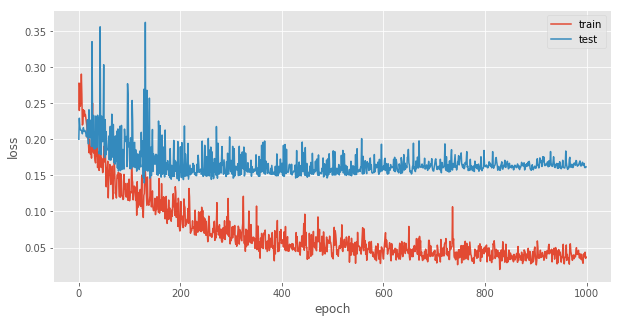

In [9]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 5.18
Best MAE: 3.96
Average RMSE: 5.64
Average MAE: 4.45


{'whiskers': [<matplotlib.lines.Line2D at 0x7f756af8f940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f756af9a0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f756af8f7f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f756af9a748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f756af9aa90>,
 'means': []}

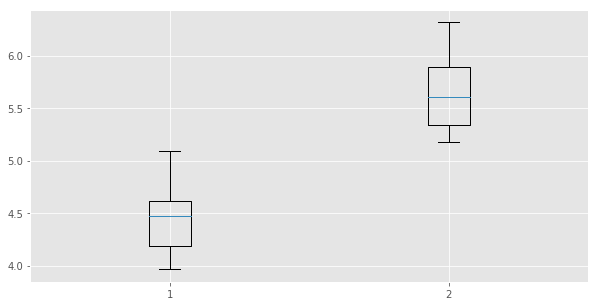

In [11]:
plt.boxplot([maes, rmses])
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

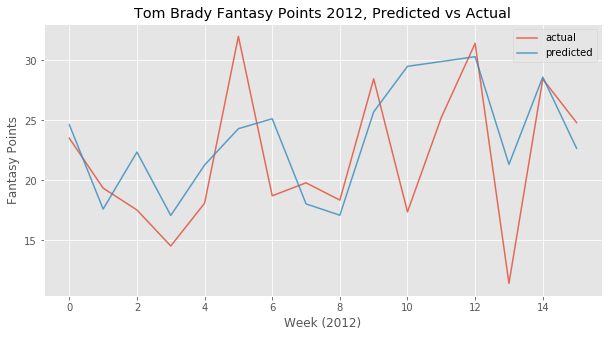

In [12]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

##### Iterative Training

In [8]:
# Remake training and test sets for iterative training
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [9]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 5
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(50, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), return_sequences=True, stateful=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit network
    for k in range(500):
        t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        print('Epoch {}/1000'.format(k))
        print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
        
    gc.collect()
             

W1107 16:50:59.163318 140547736340288 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1107 16:50:59.181757 140547736340288 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1107 16:50:59.184079 140547736340288 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1107 16:51:00.575237 140547736340288 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:13

Epoch 0/1000
4.76s
Epoch 1/1000
0.29s
Epoch 2/1000
0.28s
Epoch 3/1000
0.29s
Epoch 4/1000
0.29s
Epoch 5/1000
0.28s
Epoch 6/1000
0.29s
Epoch 7/1000
0.29s
Epoch 8/1000
0.29s
Epoch 9/1000
0.29s
Epoch 10/1000
0.28s
Epoch 11/1000
0.28s
Epoch 12/1000
0.28s
Epoch 13/1000
0.28s
Epoch 14/1000
0.29s
Epoch 15/1000
0.30s
Epoch 16/1000
0.29s
Epoch 17/1000
0.29s
Epoch 18/1000
0.31s
Epoch 19/1000
0.30s
Epoch 20/1000
0.29s
Epoch 21/1000
0.29s
Epoch 22/1000
0.29s
Epoch 23/1000
0.28s
Epoch 24/1000
0.28s
Epoch 25/1000
0.28s
Epoch 26/1000
0.28s
Epoch 27/1000
0.29s
Epoch 28/1000
0.28s
Epoch 29/1000
0.28s
Epoch 30/1000
0.28s
Epoch 31/1000
0.28s
Epoch 32/1000
0.28s
Epoch 33/1000
0.29s
Epoch 34/1000
0.35s
Epoch 35/1000
0.43s
Epoch 36/1000
0.45s
Epoch 37/1000
0.42s
Epoch 38/1000
0.44s
Epoch 39/1000
0.40s
Epoch 40/1000
0.40s
Epoch 41/1000
0.44s
Epoch 42/1000
0.43s
Epoch 43/1000
0.44s
Epoch 44/1000
0.47s
Epoch 45/1000
0.38s
Epoch 46/1000
0.35s
Epoch 47/1000
0.28s
Epoch 48/1000
0.28s
Epoch 49/1000
0.29s
Epoch 50/1

Epoch 396/1000
0.39s
Epoch 397/1000
0.40s
Epoch 398/1000
0.48s
Epoch 399/1000
0.58s
Epoch 400/1000
0.56s
Epoch 401/1000
0.57s
Epoch 402/1000
0.56s
Epoch 403/1000
0.56s
Epoch 404/1000
0.61s
Epoch 405/1000
0.56s
Epoch 406/1000
0.57s
Epoch 407/1000
1.11s
Epoch 408/1000
1.30s
Epoch 409/1000
1.34s
Epoch 410/1000
1.21s
Epoch 411/1000
1.29s
Epoch 412/1000
1.32s
Epoch 413/1000
1.40s
Epoch 414/1000
1.32s
Epoch 415/1000
1.31s
Epoch 416/1000
1.33s
Epoch 417/1000
1.37s
Epoch 418/1000
1.25s
Epoch 419/1000
1.34s
Epoch 420/1000
1.31s
Epoch 421/1000
1.28s
Epoch 422/1000
1.35s
Epoch 423/1000
1.39s
Epoch 424/1000
1.31s
Epoch 425/1000
1.38s
Epoch 426/1000
1.35s
Epoch 427/1000
1.38s
Epoch 428/1000
1.35s
Epoch 429/1000
1.36s
Epoch 430/1000
1.30s
Epoch 431/1000
1.32s
Epoch 432/1000
1.38s
Epoch 433/1000
1.31s
Epoch 434/1000
1.27s
Epoch 435/1000
1.29s
Epoch 436/1000
1.29s
Epoch 437/1000
1.32s
Epoch 438/1000
1.29s
Epoch 439/1000
1.27s
Epoch 440/1000
1.38s
Epoch 441/1000
1.32s
Epoch 442/1000
1.35s
Epoch 443/100

Epoch 292/1000
0.29s
Epoch 293/1000
0.29s
Epoch 294/1000
0.29s
Epoch 295/1000
0.28s
Epoch 296/1000
0.29s
Epoch 297/1000
0.29s
Epoch 298/1000
0.29s
Epoch 299/1000
0.29s
Epoch 300/1000
0.30s
Epoch 301/1000
0.29s
Epoch 302/1000
0.29s
Epoch 303/1000
0.29s
Epoch 304/1000
0.29s
Epoch 305/1000
0.29s
Epoch 306/1000
0.29s
Epoch 307/1000
0.29s
Epoch 308/1000
0.29s
Epoch 309/1000
0.29s
Epoch 310/1000
0.29s
Epoch 311/1000
0.29s
Epoch 312/1000
0.30s
Epoch 313/1000
0.28s
Epoch 314/1000
0.29s
Epoch 315/1000
0.31s
Epoch 316/1000
0.29s
Epoch 317/1000
0.29s
Epoch 318/1000
0.29s
Epoch 319/1000
0.38s
Epoch 320/1000
0.41s
Epoch 321/1000
0.43s
Epoch 322/1000
0.41s
Epoch 323/1000
0.41s
Epoch 324/1000
0.41s
Epoch 325/1000
0.41s
Epoch 326/1000
0.42s
Epoch 327/1000
0.44s
Epoch 328/1000
0.41s
Epoch 329/1000
0.42s
Epoch 330/1000
0.39s
Epoch 331/1000
0.54s
Epoch 332/1000
0.59s
Epoch 333/1000
0.62s
Epoch 334/1000
0.62s
Epoch 335/1000
0.60s
Epoch 336/1000
0.63s
Epoch 337/1000
0.58s
Epoch 338/1000
0.56s
Epoch 339/100

Epoch 188/1000
0.30s
Epoch 189/1000
0.29s
Epoch 190/1000
0.29s
Epoch 191/1000
0.30s
Epoch 192/1000
0.29s
Epoch 193/1000
0.29s
Epoch 194/1000
0.30s
Epoch 195/1000
0.29s
Epoch 196/1000
0.29s
Epoch 197/1000
0.30s
Epoch 198/1000
0.29s
Epoch 199/1000
0.29s
Epoch 200/1000
0.29s
Epoch 201/1000
0.29s
Epoch 202/1000
0.29s
Epoch 203/1000
0.29s
Epoch 204/1000
0.29s
Epoch 205/1000
0.29s
Epoch 206/1000
0.30s
Epoch 207/1000
0.29s
Epoch 208/1000
0.29s
Epoch 209/1000
0.29s
Epoch 210/1000
0.29s
Epoch 211/1000
0.29s
Epoch 212/1000
0.28s
Epoch 213/1000
0.29s
Epoch 214/1000
0.29s
Epoch 215/1000
0.29s
Epoch 216/1000
0.29s
Epoch 217/1000
0.29s
Epoch 218/1000
0.29s
Epoch 219/1000
0.29s
Epoch 220/1000
0.30s
Epoch 221/1000
0.29s
Epoch 222/1000
0.29s
Epoch 223/1000
0.31s
Epoch 224/1000
0.29s
Epoch 225/1000
0.29s
Epoch 226/1000
0.30s
Epoch 227/1000
0.31s
Epoch 228/1000
0.29s
Epoch 229/1000
0.29s
Epoch 230/1000
0.30s
Epoch 231/1000
0.31s
Epoch 232/1000
0.28s
Epoch 233/1000
0.29s
Epoch 234/1000
0.30s
Epoch 235/100

Epoch 83/1000
1.38s
Epoch 84/1000
1.45s
Epoch 85/1000
1.42s
Epoch 86/1000
1.33s
Epoch 87/1000
1.37s
Epoch 88/1000
1.34s
Epoch 89/1000
1.40s
Epoch 90/1000
1.39s
Epoch 91/1000
1.40s
Epoch 92/1000
1.39s
Epoch 93/1000
1.38s
Epoch 94/1000
1.39s
Epoch 95/1000
1.40s
Epoch 96/1000
1.37s
Epoch 97/1000
1.35s
Epoch 98/1000
1.38s
Epoch 99/1000
1.37s
Epoch 100/1000
1.44s
Epoch 101/1000
1.33s
Epoch 102/1000
1.32s
Epoch 103/1000
1.38s
Epoch 104/1000
1.41s
Epoch 105/1000
1.38s
Epoch 106/1000
1.38s
Epoch 107/1000
1.46s
Epoch 108/1000
1.37s
Epoch 109/1000
1.42s
Epoch 110/1000
1.39s
Epoch 111/1000
1.34s
Epoch 112/1000
1.37s
Epoch 113/1000
1.37s
Epoch 114/1000
1.37s
Epoch 115/1000
1.41s
Epoch 116/1000
1.35s
Epoch 117/1000
1.76s
Epoch 118/1000
1.94s
Epoch 119/1000
2.02s
Epoch 120/1000
2.11s
Epoch 121/1000
2.08s
Epoch 122/1000
1.95s
Epoch 123/1000
2.07s
Epoch 124/1000
2.06s
Epoch 125/1000
2.17s
Epoch 126/1000
1.43s
Epoch 127/1000
1.33s
Epoch 128/1000
1.33s
Epoch 129/1000
1.36s
Epoch 130/1000
1.37s
Epoch 131

Epoch 474/1000
1.44s
Epoch 475/1000
1.45s
Epoch 476/1000
1.38s
Epoch 477/1000
1.41s
Epoch 478/1000
1.35s
Epoch 479/1000
1.41s
Epoch 480/1000
1.43s
Epoch 481/1000
1.38s
Epoch 482/1000
1.40s
Epoch 483/1000
1.40s
Epoch 484/1000
1.48s
Epoch 485/1000
1.36s
Epoch 486/1000
1.40s
Epoch 487/1000
1.49s
Epoch 488/1000
1.38s
Epoch 489/1000
1.36s
Epoch 490/1000
1.41s
Epoch 491/1000
1.39s
Epoch 492/1000
1.40s
Epoch 493/1000
1.39s
Epoch 494/1000
1.56s
Epoch 495/1000
1.85s
Epoch 496/1000
1.94s
Epoch 497/1000
1.99s
Epoch 498/1000
1.92s
Epoch 499/1000
1.91s
Epoch 0/1000
5.42s
Epoch 1/1000
0.30s
Epoch 2/1000
0.30s
Epoch 3/1000
0.29s
Epoch 4/1000
0.31s
Epoch 5/1000
0.31s
Epoch 6/1000
0.31s
Epoch 7/1000
0.31s
Epoch 8/1000
0.42s
Epoch 9/1000
0.42s
Epoch 10/1000
0.41s
Epoch 11/1000
0.41s
Epoch 12/1000
0.42s
Epoch 13/1000
0.41s
Epoch 14/1000
0.43s
Epoch 15/1000
0.42s
Epoch 16/1000
0.42s
Epoch 17/1000
0.42s
Epoch 18/1000
0.43s
Epoch 19/1000
0.46s
Epoch 20/1000
0.58s
Epoch 21/1000
0.62s
Epoch 22/1000
0.61s
Epoc

KeyboardInterrupt: 

In [11]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 5.70
Best MAE: 4.24
Average RMSE: 5.91
Average MAE: 4.52


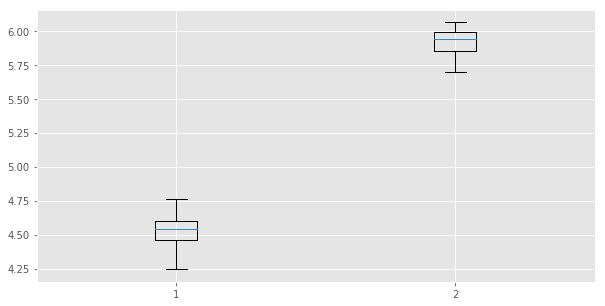

In [13]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.boxplot([maes, rmses])
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

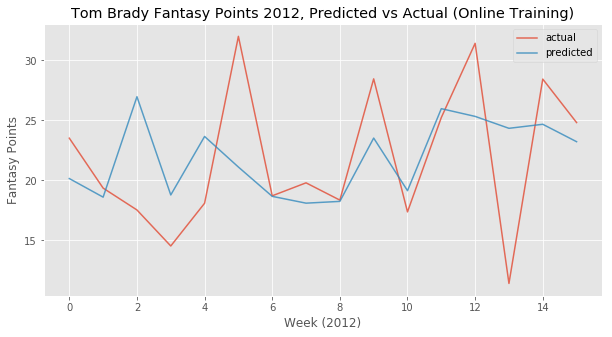

In [14]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

## 2

In [39]:
# Read in data
mccoy = pd.read_csv('../data/data_final/final/features_raw/mccoy.csv')
mccoy = mccoy.loc[:, features]
mccoy['date'] = pd.to_datetime(mccoy['date'])
mccoy = replace_nans_mean(mccoy, 30)

In [41]:
# Train + test set indices
split_date = pd.Timestamp(2012,5,1)
train_idx = mccoy.loc[mccoy['date']<split_date].index.values
test_idx = mccoy.loc[mccoy['date']>split_date].index.values

# Scale Features
mccoy.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(mccoy)
mccoy = scaler.transform(mccoy)

# Train + test sets
train, test = mccoy[train_idx], mccoy[test_idx]

In [42]:
# Create train and test sets
window = 3
X, y = build_lstm_data(mccoy, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [43]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [ ]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(50))
    model.add(Dropout(.2))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=1000, batch_size=5, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()


Train on 27 samples, validate on 14 samples
Epoch 1/1000
 - 8s - loss: 0.4596 - val_loss: 0.1595
Epoch 2/1000
 - 0s - loss: 0.2386 - val_loss: 0.1944
Epoch 3/1000
 - 0s - loss: 0.1703 - val_loss: 0.2854
Epoch 4/1000
 - 0s - loss: 0.1828 - val_loss: 0.2835
Epoch 5/1000
 - 0s - loss: 0.1963 - val_loss: 0.2751
Epoch 6/1000
 - 0s - loss: 0.1874 - val_loss: 0.2947
Epoch 7/1000
 - 0s - loss: 0.2069 - val_loss: 0.3116
Epoch 8/1000
 - 0s - loss: 0.1764 - val_loss: 0.2943
Epoch 9/1000
 - 0s - loss: 0.2163 - val_loss: 0.2552
Epoch 10/1000
 - 0s - loss: 0.1868 - val_loss: 0.2394
Epoch 11/1000
 - 0s - loss: 0.1724 - val_loss: 0.2501
Epoch 12/1000
 - 0s - loss: 0.1718 - val_loss: 0.2629
Epoch 13/1000
 - 0s - loss: 0.1800 - val_loss: 0.2528
Epoch 14/1000
 - 0s - loss: 0.1712 - val_loss: 0.2901
Epoch 15/1000
 - 0s - loss: 0.1652 - val_loss: 0.3034
Epoch 16/1000
 - 0s - loss: 0.1609 - val_loss: 0.3410
Epoch 17/1000
 - 0s - loss: 0.1443 - val_loss: 0.3252
Epoch 18/1000
 - 0s - loss: 0.1773 - val_loss: 

 - 0s - loss: 0.0582 - val_loss: 0.4958
Epoch 152/1000
 - 0s - loss: 0.0663 - val_loss: 0.4892
Epoch 153/1000
 - 0s - loss: 0.0705 - val_loss: 0.4913
Epoch 154/1000
 - 0s - loss: 0.0441 - val_loss: 0.5599
Epoch 155/1000
 - 0s - loss: 0.0729 - val_loss: 0.5509
Epoch 156/1000
 - 0s - loss: 0.0731 - val_loss: 0.4959
Epoch 157/1000
 - 0s - loss: 0.0667 - val_loss: 0.5172
Epoch 158/1000
 - 0s - loss: 0.0637 - val_loss: 0.5141
Epoch 159/1000
 - 0s - loss: 0.0536 - val_loss: 0.5363
Epoch 160/1000
 - 0s - loss: 0.0728 - val_loss: 0.5424
Epoch 161/1000
 - 0s - loss: 0.0438 - val_loss: 0.5182
Epoch 162/1000
 - 0s - loss: 0.0753 - val_loss: 0.5198
Epoch 163/1000
 - 0s - loss: 0.0633 - val_loss: 0.4855
Epoch 164/1000
 - 0s - loss: 0.0634 - val_loss: 0.5070
Epoch 165/1000
 - 0s - loss: 0.0646 - val_loss: 0.4957
Epoch 166/1000
 - 0s - loss: 0.0573 - val_loss: 0.4897
Epoch 167/1000
 - 0s - loss: 0.0633 - val_loss: 0.4583
Epoch 168/1000
 - 0s - loss: 0.0634 - val_loss: 0.5717
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.0534 - val_loss: 0.4536
Epoch 301/1000
 - 0s - loss: 0.0452 - val_loss: 0.4513
Epoch 302/1000
 - 0s - loss: 0.0428 - val_loss: 0.4741
Epoch 303/1000
 - 0s - loss: 0.0412 - val_loss: 0.4509
Epoch 304/1000
 - 0s - loss: 0.0424 - val_loss: 0.4512
Epoch 305/1000
 - 0s - loss: 0.0437 - val_loss: 0.4728
Epoch 306/1000
 - 0s - loss: 0.0377 - val_loss: 0.4310
Epoch 307/1000
 - 0s - loss: 0.0347 - val_loss: 0.4650
Epoch 308/1000
 - 0s - loss: 0.0473 - val_loss: 0.4607
Epoch 309/1000
 - 0s - loss: 0.0584 - val_loss: 0.4625
Epoch 310/1000
 - 0s - loss: 0.0428 - val_loss: 0.4875
Epoch 311/1000
 - 0s - loss: 0.0481 - val_loss: 0.4234
Epoch 312/1000
 - 0s - loss: 0.0308 - val_loss: 0.4938
Epoch 313/1000
 - 0s - loss: 0.0446 - val_loss: 0.4630
Epoch 314/1000
 - 0s - loss: 0.0480 - val_loss: 0.4043
Epoch 315/1000
 - 0s - loss: 0.0551 - val_loss: 0.4463
Epoch 316/1000
 - 0s - loss: 0.0337 - val_loss: 0.4323
Epoch 317/1000
 - 0s - loss: 0.0385 - val_loss: 0.4201
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.0563 - val_loss: 0.4528
Epoch 450/1000
 - 0s - loss: 0.0342 - val_loss: 0.4662
Epoch 451/1000
 - 0s - loss: 0.0242 - val_loss: 0.4513
Epoch 452/1000
 - 0s - loss: 0.0373 - val_loss: 0.4352
Epoch 453/1000
 - 0s - loss: 0.0294 - val_loss: 0.4167
Epoch 454/1000
 - 0s - loss: 0.0470 - val_loss: 0.4110
Epoch 455/1000
 - 0s - loss: 0.0322 - val_loss: 0.4663
Epoch 456/1000
 - 0s - loss: 0.0398 - val_loss: 0.4439
Epoch 457/1000
 - 0s - loss: 0.0457 - val_loss: 0.4425
Epoch 458/1000
 - 0s - loss: 0.0339 - val_loss: 0.4696
Epoch 459/1000
 - 0s - loss: 0.0403 - val_loss: 0.4373
Epoch 460/1000
 - 0s - loss: 0.0320 - val_loss: 0.4217
Epoch 461/1000
 - 0s - loss: 0.0334 - val_loss: 0.4423
Epoch 462/1000
 - 0s - loss: 0.0333 - val_loss: 0.4234
Epoch 463/1000
 - 0s - loss: 0.0333 - val_loss: 0.4102
Epoch 464/1000
 - 0s - loss: 0.0224 - val_loss: 0.4404
Epoch 465/1000
 - 0s - loss: 0.0389 - val_loss: 0.4382
Epoch 466/1000
 - 0s - loss: 0.0307 - val_loss: 0.4150
Epoch 467/1000
 - 0s - lo

 - 0s - loss: 0.0307 - val_loss: 0.4647
Epoch 599/1000
 - 0s - loss: 0.0358 - val_loss: 0.4371
Epoch 600/1000
 - 0s - loss: 0.0290 - val_loss: 0.4239
Epoch 601/1000
 - 0s - loss: 0.0303 - val_loss: 0.4412
Epoch 602/1000
 - 0s - loss: 0.0301 - val_loss: 0.4259
Epoch 603/1000
 - 0s - loss: 0.0290 - val_loss: 0.4483
Epoch 604/1000
 - 0s - loss: 0.0252 - val_loss: 0.4324
Epoch 605/1000
 - 0s - loss: 0.0299 - val_loss: 0.4200
Epoch 606/1000
 - 0s - loss: 0.0341 - val_loss: 0.4182
Epoch 607/1000
 - 0s - loss: 0.0310 - val_loss: 0.4224
Epoch 608/1000
 - 0s - loss: 0.0370 - val_loss: 0.4298
Epoch 609/1000
 - 0s - loss: 0.0307 - val_loss: 0.4312
Epoch 610/1000
 - 0s - loss: 0.0304 - val_loss: 0.4348
Epoch 611/1000
 - 0s - loss: 0.0266 - val_loss: 0.4399
Epoch 612/1000
 - 0s - loss: 0.0359 - val_loss: 0.4287
Epoch 613/1000
 - 0s - loss: 0.0209 - val_loss: 0.4209
Epoch 614/1000
 - 0s - loss: 0.0372 - val_loss: 0.4298
Epoch 615/1000
 - 0s - loss: 0.0276 - val_loss: 0.4383
Epoch 616/1000
 - 0s - lo

 - 0s - loss: 0.0225 - val_loss: 0.4231
Epoch 748/1000
 - 0s - loss: 0.0275 - val_loss: 0.4363
Epoch 749/1000
 - 0s - loss: 0.0323 - val_loss: 0.4179
Epoch 750/1000
 - 0s - loss: 0.0308 - val_loss: 0.3859
Epoch 751/1000
 - 0s - loss: 0.0410 - val_loss: 0.4228
Epoch 752/1000
 - 0s - loss: 0.0331 - val_loss: 0.4315
Epoch 753/1000
 - 0s - loss: 0.0384 - val_loss: 0.4074
Epoch 754/1000
 - 0s - loss: 0.0331 - val_loss: 0.4327
Epoch 755/1000
 - 0s - loss: 0.0231 - val_loss: 0.4355
Epoch 756/1000
 - 0s - loss: 0.0247 - val_loss: 0.4373
Epoch 757/1000
 - 0s - loss: 0.0275 - val_loss: 0.4495
Epoch 758/1000
 - 0s - loss: 0.0300 - val_loss: 0.4461
Epoch 759/1000
 - 0s - loss: 0.0213 - val_loss: 0.4285
Epoch 760/1000
 - 0s - loss: 0.0272 - val_loss: 0.4376
Epoch 761/1000
 - 0s - loss: 0.0267 - val_loss: 0.4294
Epoch 762/1000
 - 0s - loss: 0.0297 - val_loss: 0.4089
Epoch 763/1000
 - 0s - loss: 0.0256 - val_loss: 0.4586
Epoch 764/1000
 - 0s - loss: 0.0383 - val_loss: 0.4579
Epoch 765/1000
 - 0s - lo

Epoch 897/1000
 - 0s - loss: 0.0268 - val_loss: 0.4084
Epoch 898/1000
 - 0s - loss: 0.0302 - val_loss: 0.4394
Epoch 899/1000
 - 0s - loss: 0.0307 - val_loss: 0.4108
Epoch 900/1000
 - 0s - loss: 0.0387 - val_loss: 0.3991
Epoch 901/1000
 - 0s - loss: 0.0286 - val_loss: 0.4061
Epoch 902/1000
 - 0s - loss: 0.0271 - val_loss: 0.4202
Epoch 903/1000
 - 0s - loss: 0.0280 - val_loss: 0.4319
Epoch 904/1000
 - 0s - loss: 0.0224 - val_loss: 0.4147
Epoch 905/1000
 - 0s - loss: 0.0267 - val_loss: 0.3988
Epoch 906/1000
 - 0s - loss: 0.0257 - val_loss: 0.4120
Epoch 907/1000
 - 0s - loss: 0.0339 - val_loss: 0.4168
Epoch 908/1000
 - 0s - loss: 0.0243 - val_loss: 0.4035
Epoch 909/1000
 - 0s - loss: 0.0223 - val_loss: 0.4213
Epoch 910/1000
 - 0s - loss: 0.0199 - val_loss: 0.4257
Epoch 911/1000
 - 0s - loss: 0.0235 - val_loss: 0.4154
Epoch 912/1000
 - 0s - loss: 0.0246 - val_loss: 0.4183
Epoch 913/1000
 - 0s - loss: 0.0300 - val_loss: 0.4150
Epoch 914/1000
 - 0s - loss: 0.0245 - val_loss: 0.4068
Epoch 915/

 - 0s - loss: 0.1181 - val_loss: 0.5193
Epoch 47/1000
 - 0s - loss: 0.1184 - val_loss: 0.4558
Epoch 48/1000
 - 0s - loss: 0.1374 - val_loss: 0.3961
Epoch 49/1000
 - 0s - loss: 0.1212 - val_loss: 0.5145
Epoch 50/1000
 - 0s - loss: 0.1220 - val_loss: 0.5184
Epoch 51/1000
 - 0s - loss: 0.1230 - val_loss: 0.3797
Epoch 52/1000
 - 0s - loss: 0.1210 - val_loss: 0.4958
Epoch 53/1000
 - 0s - loss: 0.1047 - val_loss: 0.4417
Epoch 54/1000
 - 0s - loss: 0.1198 - val_loss: 0.4397
Epoch 55/1000
 - 0s - loss: 0.1088 - val_loss: 0.5114
Epoch 56/1000
 - 0s - loss: 0.1058 - val_loss: 0.5275
Epoch 57/1000
 - 0s - loss: 0.1028 - val_loss: 0.4696
Epoch 58/1000
 - 0s - loss: 0.1020 - val_loss: 0.4846
Epoch 59/1000
 - 0s - loss: 0.1130 - val_loss: 0.5208
Epoch 60/1000
 - 0s - loss: 0.0953 - val_loss: 0.5472
Epoch 61/1000
 - 0s - loss: 0.1128 - val_loss: 0.5071
Epoch 62/1000
 - 0s - loss: 0.1402 - val_loss: 0.4419
Epoch 63/1000
 - 0s - loss: 0.1096 - val_loss: 0.5995
Epoch 64/1000
 - 0s - loss: 0.1272 - val_l

 - 0s - loss: 0.0498 - val_loss: 0.5060
Epoch 197/1000
 - 0s - loss: 0.0497 - val_loss: 0.5414
Epoch 198/1000
 - 0s - loss: 0.0783 - val_loss: 0.5480
Epoch 199/1000
 - 0s - loss: 0.0482 - val_loss: 0.4044
Epoch 200/1000
 - 0s - loss: 0.0557 - val_loss: 0.5180
Epoch 201/1000
 - 0s - loss: 0.0611 - val_loss: 0.5219
Epoch 202/1000
 - 0s - loss: 0.0544 - val_loss: 0.4909
Epoch 203/1000
 - 0s - loss: 0.0437 - val_loss: 0.4692
Epoch 204/1000
 - 0s - loss: 0.0528 - val_loss: 0.5328
Epoch 205/1000
 - 0s - loss: 0.0572 - val_loss: 0.5569
Epoch 206/1000
 - 0s - loss: 0.0542 - val_loss: 0.5127
Epoch 207/1000
 - 0s - loss: 0.0498 - val_loss: 0.5475
Epoch 208/1000
 - 0s - loss: 0.0415 - val_loss: 0.5143
Epoch 209/1000
 - 0s - loss: 0.0585 - val_loss: 0.4991
Epoch 210/1000
 - 0s - loss: 0.0352 - val_loss: 0.5124
Epoch 211/1000
 - 0s - loss: 0.0500 - val_loss: 0.4870
Epoch 212/1000
 - 0s - loss: 0.0540 - val_loss: 0.5526
Epoch 213/1000
 - 0s - loss: 0.0452 - val_loss: 0.5221
Epoch 214/1000
 - 0s - lo

 - 0s - loss: 0.0642 - val_loss: 0.4648
Epoch 346/1000
 - 0s - loss: 0.0516 - val_loss: 0.5339
Epoch 347/1000
 - 0s - loss: 0.0445 - val_loss: 0.4478
Epoch 348/1000
 - 0s - loss: 0.0649 - val_loss: 0.4469
Epoch 349/1000
 - 0s - loss: 0.0322 - val_loss: 0.5280
Epoch 350/1000
 - 0s - loss: 0.0603 - val_loss: 0.4761
Epoch 351/1000
 - 0s - loss: 0.0326 - val_loss: 0.4721
Epoch 352/1000
 - 0s - loss: 0.0367 - val_loss: 0.5034
Epoch 353/1000
 - 0s - loss: 0.0434 - val_loss: 0.4736
Epoch 354/1000
 - 0s - loss: 0.0456 - val_loss: 0.4871
Epoch 355/1000
 - 0s - loss: 0.0333 - val_loss: 0.4966
Epoch 356/1000
 - 0s - loss: 0.0454 - val_loss: 0.4782
Epoch 357/1000
 - 0s - loss: 0.0361 - val_loss: 0.4839
Epoch 358/1000
 - 0s - loss: 0.0509 - val_loss: 0.4682
Epoch 359/1000
 - 0s - loss: 0.0396 - val_loss: 0.4857
Epoch 360/1000
 - 0s - loss: 0.0318 - val_loss: 0.4640
Epoch 361/1000
 - 0s - loss: 0.0353 - val_loss: 0.4762
Epoch 362/1000
 - 0s - loss: 0.0399 - val_loss: 0.5061
Epoch 363/1000
 - 0s - lo

Epoch 495/1000
 - 0s - loss: 0.0433 - val_loss: 0.4550
Epoch 496/1000
 - 0s - loss: 0.0317 - val_loss: 0.5065
Epoch 497/1000
 - 0s - loss: 0.0401 - val_loss: 0.4802
Epoch 498/1000
 - 0s - loss: 0.0364 - val_loss: 0.4632
Epoch 499/1000
 - 0s - loss: 0.0450 - val_loss: 0.4695
Epoch 500/1000
 - 0s - loss: 0.0421 - val_loss: 0.4911
Epoch 501/1000
 - 0s - loss: 0.0324 - val_loss: 0.4329
Epoch 502/1000
 - 0s - loss: 0.0516 - val_loss: 0.4258
Epoch 503/1000
 - 0s - loss: 0.0442 - val_loss: 0.4804
Epoch 504/1000
 - 0s - loss: 0.0563 - val_loss: 0.5005
Epoch 505/1000
 - 0s - loss: 0.0401 - val_loss: 0.4158
Epoch 506/1000
 - 0s - loss: 0.0649 - val_loss: 0.4659
Epoch 507/1000
 - 0s - loss: 0.0408 - val_loss: 0.5132
Epoch 508/1000
 - 0s - loss: 0.0373 - val_loss: 0.4165
Epoch 509/1000
 - 0s - loss: 0.0748 - val_loss: 0.3975
Epoch 510/1000
 - 0s - loss: 0.0444 - val_loss: 0.4575
Epoch 511/1000
 - 0s - loss: 0.0403 - val_loss: 0.4416
Epoch 512/1000
 - 0s - loss: 0.0345 - val_loss: 0.4394
Epoch 513/

Epoch 644/1000
 - 0s - loss: 0.0322 - val_loss: 0.4655
Epoch 645/1000
 - 0s - loss: 0.0302 - val_loss: 0.4387
Epoch 646/1000
 - 0s - loss: 0.0325 - val_loss: 0.4686
Epoch 647/1000
 - 0s - loss: 0.0497 - val_loss: 0.4831
Epoch 648/1000
 - 0s - loss: 0.0359 - val_loss: 0.4383
Epoch 649/1000
 - 0s - loss: 0.0353 - val_loss: 0.4542
Epoch 650/1000
 - 0s - loss: 0.0352 - val_loss: 0.4667
Epoch 651/1000
 - 0s - loss: 0.0343 - val_loss: 0.4457
Epoch 652/1000
 - 0s - loss: 0.0321 - val_loss: 0.4634
Epoch 653/1000
 - 0s - loss: 0.0355 - val_loss: 0.4607
Epoch 654/1000
 - 0s - loss: 0.0302 - val_loss: 0.4664
Epoch 655/1000
 - 0s - loss: 0.0236 - val_loss: 0.4656
Epoch 656/1000
 - 0s - loss: 0.0274 - val_loss: 0.4627
Epoch 657/1000
 - 0s - loss: 0.0323 - val_loss: 0.4759
Epoch 658/1000
 - 0s - loss: 0.0435 - val_loss: 0.4701
Epoch 659/1000
 - 0s - loss: 0.0320 - val_loss: 0.4717
Epoch 660/1000
 - 0s - loss: 0.0223 - val_loss: 0.4526
Epoch 661/1000
 - 0s - loss: 0.0292 - val_loss: 0.4699
Epoch 662/

Epoch 793/1000
 - 0s - loss: 0.0264 - val_loss: 0.4439
Epoch 794/1000
 - 0s - loss: 0.0321 - val_loss: 0.4561
Epoch 795/1000
 - 0s - loss: 0.0201 - val_loss: 0.4626
Epoch 796/1000
 - 0s - loss: 0.0291 - val_loss: 0.4289
Epoch 797/1000
 - 0s - loss: 0.0280 - val_loss: 0.4476
Epoch 798/1000
 - 0s - loss: 0.0377 - val_loss: 0.4658
Epoch 799/1000
 - 0s - loss: 0.0286 - val_loss: 0.4790
Epoch 800/1000
 - 0s - loss: 0.0357 - val_loss: 0.4540
Epoch 801/1000
 - 0s - loss: 0.0326 - val_loss: 0.4361
Epoch 802/1000
 - 0s - loss: 0.0301 - val_loss: 0.4375
Epoch 803/1000
 - 0s - loss: 0.0332 - val_loss: 0.4423
Epoch 804/1000
 - 0s - loss: 0.0281 - val_loss: 0.4402
Epoch 805/1000
 - 0s - loss: 0.0262 - val_loss: 0.4580
Epoch 806/1000
 - 0s - loss: 0.0290 - val_loss: 0.4573
Epoch 807/1000
 - 0s - loss: 0.0369 - val_loss: 0.4642
Epoch 808/1000
 - 0s - loss: 0.0246 - val_loss: 0.4411
Epoch 809/1000
 - 0s - loss: 0.0264 - val_loss: 0.4556
Epoch 810/1000
 - 0s - loss: 0.0224 - val_loss: 0.4360
Epoch 811/

Epoch 942/1000
 - 0s - loss: 0.0288 - val_loss: 0.4576
Epoch 943/1000
 - 0s - loss: 0.0234 - val_loss: 0.4304
Epoch 944/1000
 - 0s - loss: 0.0287 - val_loss: 0.4480
Epoch 945/1000
 - 0s - loss: 0.0280 - val_loss: 0.4463
Epoch 946/1000
 - 0s - loss: 0.0257 - val_loss: 0.4594
Epoch 947/1000
 - 0s - loss: 0.0295 - val_loss: 0.4303
Epoch 948/1000
 - 0s - loss: 0.0284 - val_loss: 0.4247
Epoch 949/1000
 - 0s - loss: 0.0223 - val_loss: 0.4329
Epoch 950/1000
 - 0s - loss: 0.0256 - val_loss: 0.4445
Epoch 951/1000
 - 0s - loss: 0.0231 - val_loss: 0.4487
Epoch 952/1000
 - 0s - loss: 0.0268 - val_loss: 0.4471
Epoch 953/1000
 - 0s - loss: 0.0234 - val_loss: 0.4551
Epoch 954/1000
 - 0s - loss: 0.0334 - val_loss: 0.4866
Epoch 955/1000
 - 0s - loss: 0.0340 - val_loss: 0.4286
Epoch 956/1000
 - 0s - loss: 0.0315 - val_loss: 0.4234
Epoch 957/1000
 - 0s - loss: 0.0242 - val_loss: 0.4409
Epoch 958/1000
 - 0s - loss: 0.0284 - val_loss: 0.4430
Epoch 959/1000
 - 0s - loss: 0.0210 - val_loss: 0.4695
Epoch 960/

Epoch 92/1000
 - 0s - loss: 0.0791 - val_loss: 0.5425
Epoch 93/1000
 - 0s - loss: 0.0932 - val_loss: 0.5112
Epoch 94/1000
 - 0s - loss: 0.0754 - val_loss: 0.5244
Epoch 95/1000
 - 0s - loss: 0.1030 - val_loss: 0.5243
Epoch 96/1000
 - 0s - loss: 0.0905 - val_loss: 0.6310
Epoch 97/1000
 - 0s - loss: 0.1170 - val_loss: 0.4971
Epoch 98/1000
 - 0s - loss: 0.0987 - val_loss: 0.5899
Epoch 99/1000
 - 0s - loss: 0.1081 - val_loss: 0.5318
Epoch 100/1000
 - 0s - loss: 0.0961 - val_loss: 0.5007
Epoch 101/1000
 - 0s - loss: 0.0835 - val_loss: 0.5466
Epoch 102/1000
 - 0s - loss: 0.0836 - val_loss: 0.4681
Epoch 103/1000
 - 0s - loss: 0.0928 - val_loss: 0.5410
Epoch 104/1000
 - 0s - loss: 0.0915 - val_loss: 0.5181
Epoch 105/1000
 - 0s - loss: 0.0832 - val_loss: 0.5273
Epoch 106/1000
 - 0s - loss: 0.0972 - val_loss: 0.5728
Epoch 107/1000
 - 0s - loss: 0.0906 - val_loss: 0.5545
Epoch 108/1000
 - 0s - loss: 0.0841 - val_loss: 0.6466
Epoch 109/1000
 - 0s - loss: 0.1162 - val_loss: 0.5829
Epoch 110/1000
 - 

Epoch 242/1000
 - 0s - loss: 0.0356 - val_loss: 0.5092
Epoch 243/1000
 - 0s - loss: 0.0490 - val_loss: 0.4391
Epoch 244/1000
 - 0s - loss: 0.0560 - val_loss: 0.4959
Epoch 245/1000
 - 0s - loss: 0.0546 - val_loss: 0.4215
Epoch 246/1000
 - 0s - loss: 0.0701 - val_loss: 0.4499
Epoch 247/1000
 - 0s - loss: 0.0540 - val_loss: 0.4834
Epoch 248/1000
 - 0s - loss: 0.0381 - val_loss: 0.4058
Epoch 249/1000
 - 0s - loss: 0.0580 - val_loss: 0.4374
Epoch 250/1000
 - 0s - loss: 0.0514 - val_loss: 0.4745
Epoch 251/1000
 - 0s - loss: 0.0436 - val_loss: 0.4357
Epoch 252/1000
 - 0s - loss: 0.0399 - val_loss: 0.4830
Epoch 253/1000
 - 0s - loss: 0.0536 - val_loss: 0.4557
Epoch 254/1000
 - 0s - loss: 0.0496 - val_loss: 0.4768
Epoch 255/1000
 - 0s - loss: 0.0604 - val_loss: 0.5125
Epoch 256/1000
 - 0s - loss: 0.0440 - val_loss: 0.4301
Epoch 257/1000
 - 0s - loss: 0.0433 - val_loss: 0.4752
Epoch 258/1000
 - 0s - loss: 0.0355 - val_loss: 0.4605
Epoch 259/1000
 - 0s - loss: 0.0526 - val_loss: 0.4165
Epoch 260/

Epoch 391/1000
 - 0s - loss: 0.0383 - val_loss: 0.4086
Epoch 392/1000
 - 0s - loss: 0.0402 - val_loss: 0.4138
Epoch 393/1000
 - 0s - loss: 0.0369 - val_loss: 0.4586
Epoch 394/1000
 - 0s - loss: 0.0414 - val_loss: 0.4204
Epoch 395/1000
 - 0s - loss: 0.0325 - val_loss: 0.4400
Epoch 396/1000
 - 0s - loss: 0.0378 - val_loss: 0.4511
Epoch 397/1000
 - 0s - loss: 0.0318 - val_loss: 0.4334
Epoch 398/1000
 - 0s - loss: 0.0349 - val_loss: 0.4405
Epoch 399/1000
 - 0s - loss: 0.0319 - val_loss: 0.4405
Epoch 400/1000
 - 0s - loss: 0.0465 - val_loss: 0.4212
Epoch 401/1000
 - 0s - loss: 0.0456 - val_loss: 0.4556
Epoch 402/1000
 - 0s - loss: 0.0445 - val_loss: 0.4575
Epoch 403/1000
 - 0s - loss: 0.0460 - val_loss: 0.4307
Epoch 404/1000
 - 0s - loss: 0.0430 - val_loss: 0.4525
Epoch 405/1000
 - 0s - loss: 0.0339 - val_loss: 0.4395
Epoch 406/1000
 - 0s - loss: 0.0413 - val_loss: 0.4335
Epoch 407/1000
 - 0s - loss: 0.0318 - val_loss: 0.4382
Epoch 408/1000
 - 0s - loss: 0.0349 - val_loss: 0.4484
Epoch 409/

Epoch 540/1000
 - 0s - loss: 0.0333 - val_loss: 0.4582
Epoch 541/1000
 - 0s - loss: 0.0419 - val_loss: 0.4294
Epoch 542/1000
 - 0s - loss: 0.0425 - val_loss: 0.4473
Epoch 543/1000
 - 0s - loss: 0.0294 - val_loss: 0.4309
Epoch 544/1000
 - 0s - loss: 0.0390 - val_loss: 0.4170
Epoch 545/1000
 - 0s - loss: 0.0487 - val_loss: 0.4147
Epoch 546/1000
 - 0s - loss: 0.0368 - val_loss: 0.4659
Epoch 547/1000
 - 0s - loss: 0.0334 - val_loss: 0.3879
Epoch 548/1000
 - 0s - loss: 0.0669 - val_loss: 0.4044
Epoch 549/1000
 - 0s - loss: 0.0360 - val_loss: 0.4612
Epoch 550/1000
 - 0s - loss: 0.0526 - val_loss: 0.4197
Epoch 551/1000
 - 0s - loss: 0.0267 - val_loss: 0.4337
Epoch 552/1000
 - 0s - loss: 0.0343 - val_loss: 0.4284
Epoch 553/1000
 - 0s - loss: 0.0290 - val_loss: 0.4278
Epoch 554/1000
 - 0s - loss: 0.0304 - val_loss: 0.4560
Epoch 555/1000
 - 0s - loss: 0.0373 - val_loss: 0.4382
Epoch 556/1000
 - 0s - loss: 0.0373 - val_loss: 0.4413
Epoch 557/1000
 - 0s - loss: 0.0305 - val_loss: 0.4483
Epoch 558/

Epoch 689/1000
 - 0s - loss: 0.0335 - val_loss: 0.4436
Epoch 690/1000
 - 0s - loss: 0.0309 - val_loss: 0.4104
Epoch 691/1000
 - 0s - loss: 0.0309 - val_loss: 0.4168
Epoch 692/1000
 - 0s - loss: 0.0225 - val_loss: 0.4189
Epoch 693/1000
 - 0s - loss: 0.0307 - val_loss: 0.4059
Epoch 694/1000
 - 0s - loss: 0.0310 - val_loss: 0.4204
Epoch 695/1000
 - 0s - loss: 0.0347 - val_loss: 0.4268
Epoch 696/1000
 - 0s - loss: 0.0295 - val_loss: 0.4158
Epoch 697/1000
 - 0s - loss: 0.0320 - val_loss: 0.4483
Epoch 698/1000
 - 0s - loss: 0.0403 - val_loss: 0.4283
Epoch 699/1000
 - 0s - loss: 0.0289 - val_loss: 0.4308
Epoch 700/1000
 - 0s - loss: 0.0358 - val_loss: 0.4225
Epoch 701/1000
 - 0s - loss: 0.0272 - val_loss: 0.4155
Epoch 702/1000
 - 0s - loss: 0.0267 - val_loss: 0.4348
Epoch 703/1000
 - 0s - loss: 0.0284 - val_loss: 0.4269
Epoch 704/1000
 - 0s - loss: 0.0291 - val_loss: 0.4115
Epoch 705/1000
 - 0s - loss: 0.0288 - val_loss: 0.4171
Epoch 706/1000
 - 0s - loss: 0.0353 - val_loss: 0.4232
Epoch 707/

Epoch 838/1000
 - 0s - loss: 0.0319 - val_loss: 0.4238
Epoch 839/1000
 - 0s - loss: 0.0281 - val_loss: 0.4249
Epoch 840/1000
 - 0s - loss: 0.0241 - val_loss: 0.4101
Epoch 841/1000
 - 0s - loss: 0.0336 - val_loss: 0.4078
Epoch 842/1000
 - 0s - loss: 0.0293 - val_loss: 0.4350
Epoch 843/1000
 - 0s - loss: 0.0377 - val_loss: 0.3859
Epoch 844/1000
 - 0s - loss: 0.0352 - val_loss: 0.4060
Epoch 845/1000
 - 0s - loss: 0.0317 - val_loss: 0.4025
Epoch 846/1000
 - 0s - loss: 0.0334 - val_loss: 0.4018
Epoch 847/1000
 - 0s - loss: 0.0278 - val_loss: 0.4428
Epoch 848/1000
 - 0s - loss: 0.0377 - val_loss: 0.4223
Epoch 849/1000
 - 0s - loss: 0.0381 - val_loss: 0.4088
Epoch 850/1000
 - 0s - loss: 0.0361 - val_loss: 0.4361
Epoch 851/1000
 - 0s - loss: 0.0237 - val_loss: 0.4081
Epoch 852/1000
 - 0s - loss: 0.0302 - val_loss: 0.4058
Epoch 853/1000
 - 0s - loss: 0.0293 - val_loss: 0.4404
Epoch 854/1000
 - 0s - loss: 0.0395 - val_loss: 0.4075
Epoch 855/1000
 - 0s - loss: 0.0271 - val_loss: 0.3998
Epoch 856/

Epoch 987/1000
 - 0s - loss: 0.0220 - val_loss: 0.3867
Epoch 988/1000
 - 0s - loss: 0.0290 - val_loss: 0.4058
Epoch 989/1000
 - 0s - loss: 0.0253 - val_loss: 0.3990
Epoch 990/1000
 - 0s - loss: 0.0334 - val_loss: 0.3988
Epoch 991/1000
 - 0s - loss: 0.0343 - val_loss: 0.4005
Epoch 992/1000
 - 0s - loss: 0.0237 - val_loss: 0.3962
Epoch 993/1000
 - 0s - loss: 0.0237 - val_loss: 0.3987
Epoch 994/1000
 - 0s - loss: 0.0245 - val_loss: 0.3956
Epoch 995/1000
 - 0s - loss: 0.0259 - val_loss: 0.4087
Epoch 996/1000
 - 0s - loss: 0.0261 - val_loss: 0.3876
Epoch 997/1000
 - 0s - loss: 0.0205 - val_loss: 0.3996
Epoch 998/1000
 - 0s - loss: 0.0252 - val_loss: 0.4120
Epoch 999/1000
 - 0s - loss: 0.0273 - val_loss: 0.3900
Epoch 1000/1000
 - 0s - loss: 0.0233 - val_loss: 0.3968
Train on 27 samples, validate on 14 samples
Epoch 1/1000
 - 9s - loss: 0.4909 - val_loss: 0.1696
Epoch 2/1000
 - 0s - loss: 0.2507 - val_loss: 0.2169
Epoch 3/1000
 - 0s - loss: 0.1896 - val_loss: 0.3416
Epoch 4/1000
 - 0s - loss:

 - 0s - loss: 0.0715 - val_loss: 0.4948
Epoch 138/1000
 - 0s - loss: 0.0742 - val_loss: 0.4869
Epoch 139/1000
 - 0s - loss: 0.0796 - val_loss: 0.4670
Epoch 140/1000
 - 0s - loss: 0.0648 - val_loss: 0.4666
Epoch 141/1000
 - 0s - loss: 0.0748 - val_loss: 0.5064
Epoch 142/1000
 - 0s - loss: 0.0999 - val_loss: 0.4910
Epoch 143/1000
 - 0s - loss: 0.0749 - val_loss: 0.4461
Epoch 144/1000
 - 0s - loss: 0.0687 - val_loss: 0.5595
Epoch 145/1000
 - 0s - loss: 0.0944 - val_loss: 0.4351
Epoch 146/1000
 - 0s - loss: 0.0706 - val_loss: 0.4945
Epoch 147/1000
 - 0s - loss: 0.0678 - val_loss: 0.4816
Epoch 148/1000
 - 0s - loss: 0.0658 - val_loss: 0.4862
Epoch 149/1000
 - 0s - loss: 0.0611 - val_loss: 0.5224
Epoch 150/1000
 - 0s - loss: 0.0761 - val_loss: 0.4469
Epoch 151/1000
 - 0s - loss: 0.0769 - val_loss: 0.5055
Epoch 152/1000
 - 0s - loss: 0.0670 - val_loss: 0.4564
Epoch 153/1000
 - 0s - loss: 0.0771 - val_loss: 0.4952
Epoch 154/1000
 - 0s - loss: 0.0736 - val_loss: 0.4780
Epoch 155/1000
 - 0s - lo

 - 0s - loss: 0.0443 - val_loss: 0.4277
Epoch 287/1000
 - 0s - loss: 0.0384 - val_loss: 0.4447
Epoch 288/1000
 - 0s - loss: 0.0338 - val_loss: 0.4264
Epoch 289/1000
 - 0s - loss: 0.0508 - val_loss: 0.4770
Epoch 290/1000
 - 0s - loss: 0.0423 - val_loss: 0.4375
Epoch 291/1000
 - 0s - loss: 0.0402 - val_loss: 0.4400
Epoch 292/1000
 - 0s - loss: 0.0393 - val_loss: 0.4241
Epoch 293/1000
 - 0s - loss: 0.0486 - val_loss: 0.4359
Epoch 294/1000
 - 0s - loss: 0.0382 - val_loss: 0.4992
Epoch 295/1000
 - 0s - loss: 0.0705 - val_loss: 0.4630
Epoch 296/1000
 - 0s - loss: 0.0401 - val_loss: 0.4306
Epoch 297/1000
 - 0s - loss: 0.0416 - val_loss: 0.4885
Epoch 298/1000
 - 0s - loss: 0.0386 - val_loss: 0.4476
Epoch 299/1000
 - 0s - loss: 0.0501 - val_loss: 0.4369
Epoch 300/1000
 - 0s - loss: 0.0388 - val_loss: 0.4776
Epoch 301/1000
 - 0s - loss: 0.0443 - val_loss: 0.4168
Epoch 302/1000
 - 0s - loss: 0.0427 - val_loss: 0.4094
Epoch 303/1000
 - 0s - loss: 0.0410 - val_loss: 0.4609
Epoch 304/1000
 - 0s - lo

 - 0s - loss: 0.0325 - val_loss: 0.4406
Epoch 436/1000
 - 0s - loss: 0.0268 - val_loss: 0.4507
Epoch 437/1000
 - 0s - loss: 0.0289 - val_loss: 0.4665
Epoch 438/1000
 - 0s - loss: 0.0354 - val_loss: 0.4453
Epoch 439/1000
 - 0s - loss: 0.0300 - val_loss: 0.4155
Epoch 440/1000
 - 0s - loss: 0.0363 - val_loss: 0.4572
Epoch 441/1000
 - 0s - loss: 0.0434 - val_loss: 0.4492
Epoch 442/1000
 - 0s - loss: 0.0369 - val_loss: 0.4445
Epoch 443/1000
 - 0s - loss: 0.0467 - val_loss: 0.4465
Epoch 444/1000
 - 0s - loss: 0.0374 - val_loss: 0.4352
Epoch 445/1000
 - 0s - loss: 0.0307 - val_loss: 0.4763
Epoch 446/1000
 - 0s - loss: 0.0440 - val_loss: 0.4361
Epoch 447/1000
 - 0s - loss: 0.0291 - val_loss: 0.4727
Epoch 448/1000
 - 0s - loss: 0.0285 - val_loss: 0.4705
Epoch 449/1000
 - 0s - loss: 0.0312 - val_loss: 0.4433
Epoch 450/1000
 - 0s - loss: 0.0299 - val_loss: 0.4604
Epoch 451/1000
 - 0s - loss: 0.0445 - val_loss: 0.4219
Epoch 452/1000
 - 0s - loss: 0.0328 - val_loss: 0.4282
Epoch 453/1000
 - 0s - lo

 - 0s - loss: 0.0362 - val_loss: 0.4226
Epoch 585/1000
 - 0s - loss: 0.0307 - val_loss: 0.4449
Epoch 586/1000
 - 0s - loss: 0.0392 - val_loss: 0.4359
Epoch 587/1000
 - 0s - loss: 0.0294 - val_loss: 0.4230
Epoch 588/1000
 - 0s - loss: 0.0389 - val_loss: 0.4853
Epoch 589/1000
 - 0s - loss: 0.0391 - val_loss: 0.4237
Epoch 590/1000
 - 0s - loss: 0.0425 - val_loss: 0.4128
Epoch 591/1000
 - 0s - loss: 0.0467 - val_loss: 0.4661
Epoch 592/1000
 - 0s - loss: 0.0381 - val_loss: 0.4595
Epoch 593/1000
 - 0s - loss: 0.0273 - val_loss: 0.4574
Epoch 594/1000
 - 0s - loss: 0.0302 - val_loss: 0.4520
Epoch 595/1000
 - 0s - loss: 0.0332 - val_loss: 0.4340
Epoch 596/1000
 - 0s - loss: 0.0297 - val_loss: 0.4442
Epoch 597/1000
 - 0s - loss: 0.0390 - val_loss: 0.4462
Epoch 598/1000
 - 0s - loss: 0.0300 - val_loss: 0.4368
Epoch 599/1000
 - 0s - loss: 0.0355 - val_loss: 0.4481
Epoch 600/1000
 - 0s - loss: 0.0339 - val_loss: 0.4430
Epoch 601/1000
 - 0s - loss: 0.0289 - val_loss: 0.4418
Epoch 602/1000
 - 0s - lo

 - 0s - loss: 0.0321 - val_loss: 0.4421
Epoch 734/1000
 - 0s - loss: 0.0391 - val_loss: 0.4305
Epoch 735/1000
 - 0s - loss: 0.0284 - val_loss: 0.4444
Epoch 736/1000
 - 0s - loss: 0.0282 - val_loss: 0.4134
Epoch 737/1000
 - 0s - loss: 0.0369 - val_loss: 0.4125
Epoch 738/1000
 - 0s - loss: 0.0244 - val_loss: 0.4319
Epoch 739/1000
 - 0s - loss: 0.0315 - val_loss: 0.4155
Epoch 740/1000
 - 0s - loss: 0.0324 - val_loss: 0.4292
Epoch 741/1000
 - 0s - loss: 0.0248 - val_loss: 0.4466
Epoch 742/1000
 - 0s - loss: 0.0325 - val_loss: 0.4496
Epoch 743/1000
 - 0s - loss: 0.0210 - val_loss: 0.4488
Epoch 744/1000
 - 0s - loss: 0.0277 - val_loss: 0.4177
Epoch 745/1000
 - 0s - loss: 0.0266 - val_loss: 0.4387
Epoch 746/1000
 - 0s - loss: 0.0319 - val_loss: 0.4177
Epoch 747/1000
 - 0s - loss: 0.0285 - val_loss: 0.4652
Epoch 748/1000
 - 0s - loss: 0.0305 - val_loss: 0.4450
Epoch 749/1000
 - 0s - loss: 0.0289 - val_loss: 0.4264
Epoch 750/1000
 - 0s - loss: 0.0265 - val_loss: 0.4405
Epoch 751/1000
 - 0s - lo

 - 0s - loss: 0.0256 - val_loss: 0.4310
Epoch 883/1000
 - 0s - loss: 0.0234 - val_loss: 0.4325
Epoch 884/1000
 - 0s - loss: 0.0238 - val_loss: 0.4249
Epoch 885/1000
 - 0s - loss: 0.0262 - val_loss: 0.4328
Epoch 886/1000
 - 0s - loss: 0.0262 - val_loss: 0.4534
Epoch 887/1000
 - 0s - loss: 0.0337 - val_loss: 0.4351
Epoch 888/1000
 - 0s - loss: 0.0403 - val_loss: 0.4223
Epoch 889/1000
 - 0s - loss: 0.0264 - val_loss: 0.4598
Epoch 890/1000
 - 0s - loss: 0.0224 - val_loss: 0.4352
Epoch 891/1000
 - 0s - loss: 0.0194 - val_loss: 0.4435
Epoch 892/1000
 - 0s - loss: 0.0343 - val_loss: 0.4354
Epoch 893/1000
 - 0s - loss: 0.0265 - val_loss: 0.4492
Epoch 894/1000
 - 0s - loss: 0.0323 - val_loss: 0.4513
Epoch 895/1000
 - 0s - loss: 0.0184 - val_loss: 0.4339
Epoch 896/1000
 - 0s - loss: 0.0236 - val_loss: 0.4480
Epoch 897/1000
 - 0s - loss: 0.0246 - val_loss: 0.4557
Epoch 898/1000
 - 0s - loss: 0.0239 - val_loss: 0.4418
Epoch 899/1000
 - 0s - loss: 0.0237 - val_loss: 0.4350
Epoch 900/1000
 - 0s - lo

 - 0s - loss: 0.1424 - val_loss: 0.4498
Epoch 32/1000
 - 0s - loss: 0.1750 - val_loss: 0.4375
Epoch 33/1000
 - 0s - loss: 0.1750 - val_loss: 0.2575
Epoch 34/1000
 - 0s - loss: 0.1488 - val_loss: 0.3847
Epoch 35/1000
 - 0s - loss: 0.1181 - val_loss: 0.4709
Epoch 36/1000
 - 0s - loss: 0.1431 - val_loss: 0.3350
Epoch 37/1000
 - 0s - loss: 0.1549 - val_loss: 0.3103
Epoch 38/1000
 - 0s - loss: 0.1313 - val_loss: 0.4062
Epoch 39/1000
 - 0s - loss: 0.1351 - val_loss: 0.3866
Epoch 40/1000
 - 0s - loss: 0.1416 - val_loss: 0.4347
Epoch 41/1000
 - 0s - loss: 0.1267 - val_loss: 0.3948
Epoch 42/1000
 - 0s - loss: 0.1308 - val_loss: 0.3675
Epoch 43/1000
 - 0s - loss: 0.1342 - val_loss: 0.5156
Epoch 44/1000
 - 0s - loss: 0.1404 - val_loss: 0.3875
Epoch 45/1000
 - 0s - loss: 0.1529 - val_loss: 0.3488
Epoch 46/1000
 - 0s - loss: 0.1217 - val_loss: 0.4616
Epoch 47/1000
 - 0s - loss: 0.1160 - val_loss: 0.4311
Epoch 48/1000
 - 0s - loss: 0.1143 - val_loss: 0.4327
Epoch 49/1000
 - 0s - loss: 0.1178 - val_l

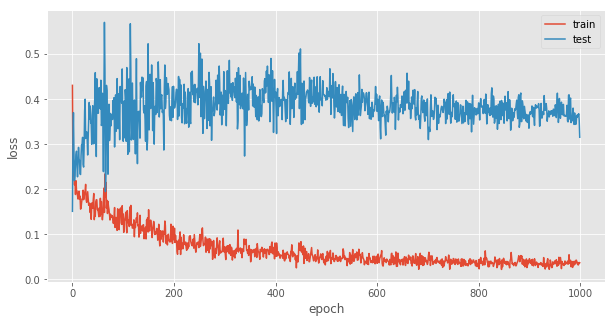

In [17]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [18]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 11.37
Best MAE: 10.08
Average RMSE: 13.42
Average MAE: 12.08


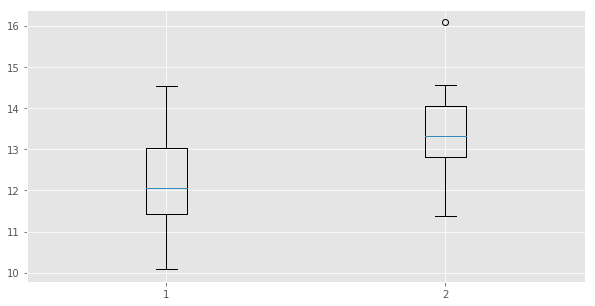

In [19]:
plt.boxplot([maes, rmses])
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

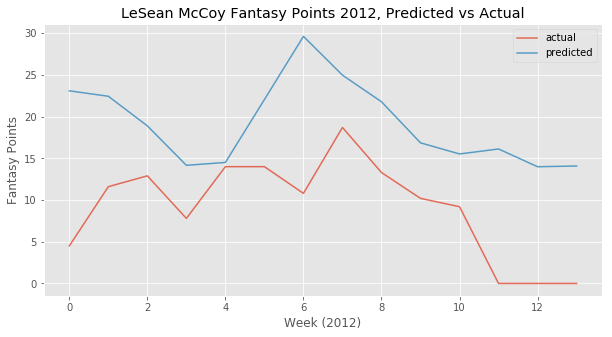

In [20]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')